# Разработка решений для персонализации предложений постоянным клиентам магазина "В один клик"

## Введение

<font color='navy'><b><u>Целевая задача Заказчика</b></u><i> - удерживать активность постоянных клиентов с помощью персонализированных предложений</i><br>

<Font color='navy'><b><i><u>Цель исследования </b></i></u>- разработка рекомендаций для интернет-магазина "В один клик", которые позволят персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

<Font color='navy'><b><i><u>Задачи исследования</b></i></u><br>&nbsp;&nbsp;&nbsp;1. оценить ключевые характеристики покупателей магазина: покупательские предпочтения, время, проводимое на сайте и количество просмотров<br>&nbsp;&nbsp;&nbsp;2. сегментировать покупателей<br>&nbsp;&nbsp;&nbsp;3. построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.<br>&nbsp;&nbsp;&nbsp;4. разработать персонализированные предложения для различных покупательских групп.

<Font color='navy'><b><i><u>План работы</b></i></u><br>1. загрузка, обзор и предобработка данных<br>&nbsp;&nbsp;&nbsp;- загрузка библиотек<br>&nbsp;&nbsp;&nbsp;- загрузка и обзор данных<br>&nbsp;&nbsp;&nbsp;- предобработка данных<br>
<Font color='navy'>2. анализ данных<br>&nbsp;&nbsp;&nbsp;- анализ данных поведении покупателей, о выручке и прибыли магазина <br>&nbsp;&nbsp;&nbsp;- анализ объединенных данных в рарезе покупательской активности<br>&nbsp;&nbsp;&nbsp;- корреляционный анализ данных <br>
<Font color='navy'>3. выбор наилучшей модели пронозирования снижения покупательской активности<br>
<Font color='navy'>4. анализ важности признаков<br>
<Font color='navy'>5. сегментация покупателей<br>

## Загрузка и обзор днных

### Загрузка библиотек

In [9]:
# импорт основных библиотек
import pandas as pd
import os
import numpy as np
import sklearn
#!pip install shap
import shap
#!pip install phik
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings

# импорт модулей для разделения данных и создания моделей МО
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

# загружаем необходимые инструменты для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импорт модулей для масштабирования и кодирования
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler)
 
# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импорт модулей для расчета метрик
from sklearn.metrics import (mean_absolute_error, \
                            r2_score, \
                            mean_squared_error, \
                            recall_score,\
                            precision_score, \
                            accuracy_score, \
                            roc_auc_score, \
                            confusion_matrix)

# импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

# Снимем ограничения на вывод данных в pandas-таблице
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

#выделение заголовков таблиц
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-weight", "bold"),
                   ("font-size", "120%"),
                   ("color", 'black')])]

### Загрузка и обзор данных

In [11]:
# функция для обзора данных
def display_df_info(data):
    display(data.head(5))
    print('-'*100)
    data.info()
    print('-'*100)
    print('Количество столбцов - {}, количество записей - {}'.format(data.shape[1], data.shape[0]))
   
    dupl = data.duplicated().sum()
    if dupl != 0:
        print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / data.shape[0]))
    else:
        print('Дубликаты записей не выявлены')
    
    if data.isnull().sum().sum() != 0:
            def pass_value_barh(data):
                try:
                    (data.isna().mean()*100).to_frame() \
                    .rename(columns = {0:'space'}) \
                    .query('space > 0') \
                    .sort_values(by = 'space', ascending = True) \
                    .plot(kind = 'barh', figsize = (10, 3), legend = False, fontsize = 8, color='royalblue', \
                                   title ='Пропущенные значения, %', \
                                   xlabel = 'Процент пропусков', \
                                   ylabel='Столбцы с пропусками', \
                                   grid=True, style='-',)
                    plt.show();    
                except:
                    print('Пропусков данных нет')
    else:
        print('Пропусков данных нет')

In [12]:
# загрузим предоставленные датасеты
## 1.данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
pth1 = 'C:\\Data_Science\\projects\\One_Click\\market_file.csv'
## 2. данные о выручке, которую получает магазин с покупателя
pth2 = 'C:\\Data_Science\\projects\\One_Click\\market_money.csv'
## 3. данные о времени (в минутах), которое покупатель провёл на сайте в течение периода
pth3 = 'C:\\Data_Science\\projects\\One_Click\\market_time.csv'
## 4. данные о среднемесячной прибыли покупателя за последние 3 месяца
pth4 = 'C:\\Data_Science\\projects\\One_Click\\money.csv'

if os.path.exists(pth1):
    market_file = pd.read_csv(pth1)
else:
    print('Something is wrong with pth1')
if os.path.exists(pth2):
    market_money = pd.read_csv(pth2)
else:
    print('Something is wrong  with pth2')
if os.path.exists(pth3):
    market_time = pd.read_csv(pth3)
else:
    print('Something is wrong  with pth3')
if os.path.exists(pth4):
    money = pd.read_csv(pth4, sep=';')
else:
    print('Something is wrong  with pth4')


In [13]:
 display_df_info(market_file)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                3.40                     5           121               0.00   
1                4.40                     4           819               0.75   
2                4.90                     3           539               0.14   
3                3.20                     5           896               0.99   
4                5.10                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  


Датасет <b>`market_file`</b> содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении<br>
`id` — номер покупателя в корпоративной базе данных, тип данных int - соответствует описанию<br>
`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень», тип данных object - соответствует описанию<br>
`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт», тип данных object - соответствует описанию<br>
`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре (Согласие на это даёт покупатель), тип данных object - соответствует описанию<br>
`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента), тип данных float -  соответствует описанию<br>
`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце, тип данных int - соответствует описанию<br>
`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, тип данных int - соответствует описанию<br>
`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев, тип данных float - соответствует описанию<br>
`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев, тип данных object - соответствует описанию<br>
`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца, тип данных int - соответствует описанию<br>
`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца, тип данных int - соответствует описанию<br>
`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта, тип данных int - соответствует описанию<br>
`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, тип данных int - соответствует описанию<br>

In [15]:
 display_df_info(market_money)

id               Период  Выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 3, количество записей - 3900
Дубликаты записей не выявлены
Пропусков данных нет


Датасет <b>`market_money`</b> содеражит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом<br>
`id` — номер покупателя в корпоративной базе данных, тип данных int - соответствует описанию<br>
`Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц', тип данных obj - соответствует описанию<br>
`Выручка` — сумма выручки за период, тип данных float - соответствует описанию<br>

In [17]:
 display_df_info(market_time)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 3, количество записей - 2600
Дубликаты записей не выявлены
Пропусков данных нет


Датасет <b>`market_time`</b> содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода<br>
`id` — номер покупателя в корпоративной базе данных, тип данных int - соответствует описанию<br>
`Период` — название периода, во время которого зафиксировано общее время, тип данных obj - соответствует описанию<br>
`минут` — значение времени, проведённого на сайте, в минутах, тип данных int - соответствует описанию<br>

In [19]:
display_df_info(money)

id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
----------------------------------------------------------------------------------------------------
Количество столбцов - 2, количество записей - 1300
Дубликаты записей не выявлены
Пропусков данных нет


Датасет <b>`money`</b> содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю<br>
`id` — номер покупателя в корпоративной базе данных, тип данных obj - <b>не соответствует описанию</b><br>`Прибыль` — значение прибыли, тип данных float - соответствует описанию<br>

### Предобработка данных

<font color='navy'> <u><i>Из информации о данных видно</u>,</i> что </br>
<font color='navy'>1. во всех датасетах некорректное наименование колонок</br>
<font color='navy'>2. во всех датасетах нет пропусков и явных дубликатов данных</br>
<font color='navy'>3. в датасете `money` тип данных в колонке `Прибыль` не соответсвуют типу: obj вместо float64</br>

In [23]:
# изменим названия колонок
market_file.columns = ['id', 'buying_activ', 'service_type', 'allow_message', 'market_activ_6mnth',\
                       'market_activ_current', 'duration', 'promo_buy', 'popular_cat', 'avg_cat_views', \
                       'not_paid_item_per_q', 'service_error', 'pages_per_visit']
market_money.columns = ['id', 'period', 'revenue']
market_time.columns = ['id', 'period', 'minutes']
money.columns = ['id', 'profit']

In [24]:
# Изменим тип данных в колонках
money['profit'] = money['profit'].replace(',','.', regex=True).astype(float)

In [25]:
# посмотрим на уникальные значения в текстовых колонках
for col in market_file.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_file')
    print('   - колонка', col, market_file[col].unique())
print('-'*100)
for col in market_money.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_money')
    print('   - колонка', col, market_money[col].unique())
print('-'*100)
for col in market_time.select_dtypes(exclude='number').columns.tolist():
    print('Уникальные значения текстовых колонок в датасете market_time')
    print('   - колонка', col, market_time[col].unique())

Уникальные значения текстовых колонок в датасете market_file
   - колонка buying_activ ['Снизилась' 'Прежний уровень']
Уникальные значения текстовых колонок в датасете market_file
   - колонка service_type ['премиум' 'стандартт' 'стандарт']
Уникальные значения текстовых колонок в датасете market_file
   - колонка allow_message ['да' 'нет']
Уникальные значения текстовых колонок в датасете market_file
   - колонка popular_cat ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете market_money
   - колонка period ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
----------------------------------------------------------------------------------------------------
Уникальные значения текстовых колонок в датасете market_time
   - колонк

<font color='navy'><u><i>Из представленной выше информации видно, что есть опечатки</u></i>:<br> - в датасете market_file в колонке service_type 'стандартт'<br> - в датасете market_time в колонке period 'предыдцщий_месяц'<br>Исправим их и повторно проверим на дубликаты

In [27]:
market_file['service_type'] = market_file['service_type'].replace(['стандартт'], 'стандарт')
market_time['period'] = market_time['period'].replace(['предыдцщий_месяц'], 'предыдущий_месяц')

In [28]:
# проверим наличие явных дубликатов в датасете market_file
dupl_2 = market_file.duplicated().sum()
if dupl_2 != 0:
    print('Выявлено {:,.0f} дубликатов записей, их количество составляет {:.2%} от всех записей'.format(dupl, dupl / market_file.shape[0]))
else:
    print('Дубликаты записей не выявлены')

Дубликаты записей не выявлены


### Резюме обзора и пердобработки данных

<font color='Darkblue'><b>A.</b> Для исследования предоставлено 4 датасета<br>&nbsp;&nbsp;&nbsp;<b>1) `market_file`</b> содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении<br>&nbsp;&nbsp;&nbsp;<i>1300 записи, 13 колонок, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Покупательская активность` — рассчитанный класс покупательской активности<br>`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт»<br>`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре<br>`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев<br>`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце<br>`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте<br>`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев <br>`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев<br>`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца<br>`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца<br>`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта<br>`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца<br>&nbsp;&nbsp;&nbsp;<b>2) `market_money`</b>содеражит данные о выручке, которую получает магазин с покупателя<br>&nbsp;&nbsp;&nbsp;<i>3900 записи, 3 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Период` - название периода, во время которого зафиксирова выручка<br>`Выручка` - сумма выручки, полученная магазином за период<br>&nbsp;&nbsp;&nbsp;<b>3) `market_time`</b>содеражит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода<br>&nbsp;&nbsp;&nbsp;<i>2600 записи, 3 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Период` — название периода, во время которого зафиксировано общее время<br>`минут` — значение времени, проведённого на сайте, в минутах<br>&nbsp;&nbsp;&nbsp;<b>4) `money`</b>содержит данные о среднемесячной прибыли покупателя за последние 3 месяца<br>&nbsp;&nbsp;&nbsp;<i>1300 записи, 2 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Прибыль` — значение прибыли<br>
<font color='Darkblue'><b>B.</b> В рамках предподготовки данных <br>&nbsp;&nbsp;&nbsp; - стандартизированы названия колонок<br>&nbsp;&nbsp;&nbsp; - удалены опечатки в значениях текстовых колонок<br>

## Анализ данных

### Анализ данных о поведении покупателей

In [33]:
display(market_file.describe(percentiles=[.125, .5, .875]))
market_file.describe(include='object')

id  market_activ_6mnth  market_activ_current  duration  \
count   1,300.00            1,300.00              1,300.00  1,300.00   
mean  215,997.50                4.25                  4.01    601.90   
std       375.42                1.01                  0.70    249.86   
min   215,348.00                0.90                  3.00    110.00   
12.5% 215,510.38                3.30                  3.00    284.75   
50%   215,997.50                4.20                  4.00    606.00   
87.5% 216,484.62                5.50                  5.00    912.25   
max   216,647.00                6.60                  5.00  1,079.00   

       promo_buy  avg_cat_views  not_paid_item_per_q  service_error  \
count   1,300.00       1,300.00             1,300.00       1,300.00   
mean        0.32           3.27                 2.84           4.19   
std         0.25           1.36                 1.97           1.96   
min         0.00           1.00                 0.00           0.00   
12.5%       0.14           2.00                 1.00           2.00   
50%         0.24           3.00                 3.00           4.00   
87.5%       0.89           5.00                 5.00           7.00   
max         0.99           6.00                10.00           9.00   

       pages_per_visit  
count         1,300.00  
mean              8.18  
std               3.98  
min               1.00  
12.5%             4.00  
50%               8.00  
87.5%            13.00  
max              20.00

buying_activ service_type allow_message       popular_cat
count              1300         1300          1300              1300
unique                2            2             2                 6
top     Прежний уровень     стандарт            да  Товары для детей
freq                802          924           962               330

<font color='Darkblue'><i>Посмотрим распределение непрерывных количественных признаков `market_activ_6mnt`, `duration` и `promo_buy` 

In [35]:
def continuous_num_feature_plot(df, column):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.set_title(f'распределение признака "{column}"', color = 'navy')
    sns.histplot(data=df, x=column, facecolor = 'cornflowerblue', \
                 color='navy',edgecolor='navy', \
                 stat='density', common_norm=False, kde=True, ax = ax)
    ax.set_xlabel(f'значения "{column}"', color = 'navy')
    ax.set_ylabel('плотность распределения', color = 'navy')
    plt.show()

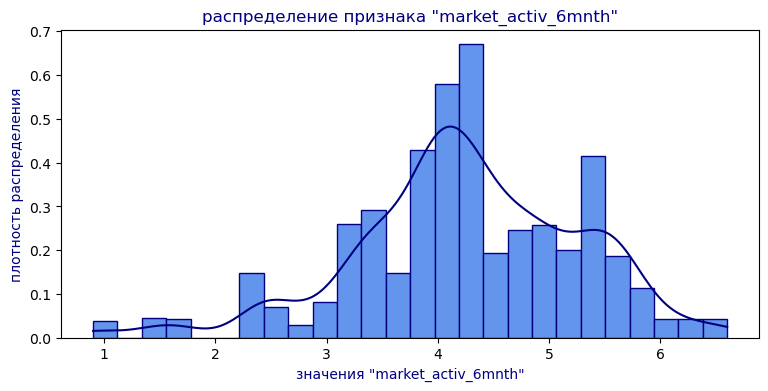

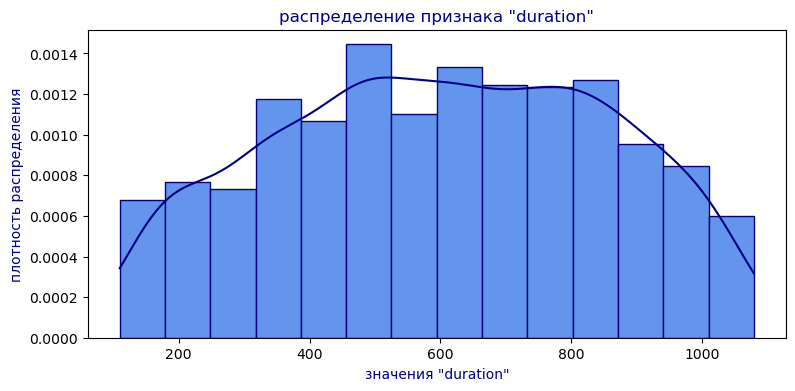

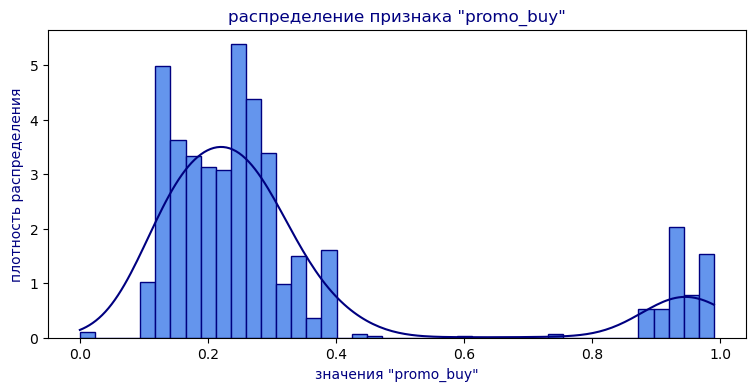

In [36]:
continuous_num_cols = ['market_activ_6mnth', 'duration', 'promo_buy']
for column in continuous_num_cols:
    continuous_num_feature_plot(market_file, column)

In [37]:
def descrete_num_feature_plot(df, column):
    plt.title(f'распределение признака "{column}"', color = 'navy')
    sns.countplot(x = column, data=df, \
                  palette ={'Снизилась': 'royalblue', 'Прежний уровень': 'cornflowerblue'}, 
                  hue='buying_activ', stat="percent")
    plt.xlabel(f'количество "{column}"', color = 'navy')
    plt.xticks(rotation=45, color='navy', fontsize=7)
    plt.ylabel('процент покупателей', color = 'navy')
    plt.legend(fontsize = 8, \
               bbox_to_anchor= (1, 1), \
               title="покупательская \nактивность", \
               title_fontsize = 9)
    plt.show();

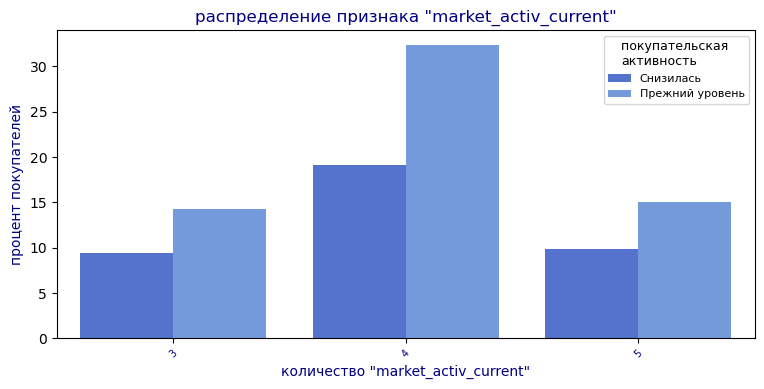

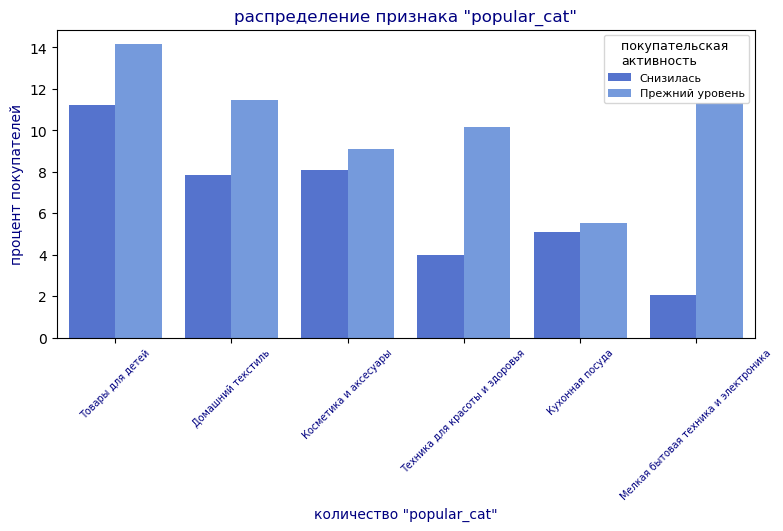

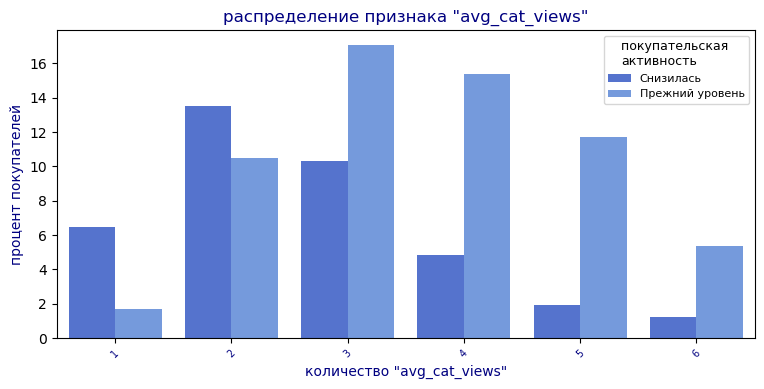

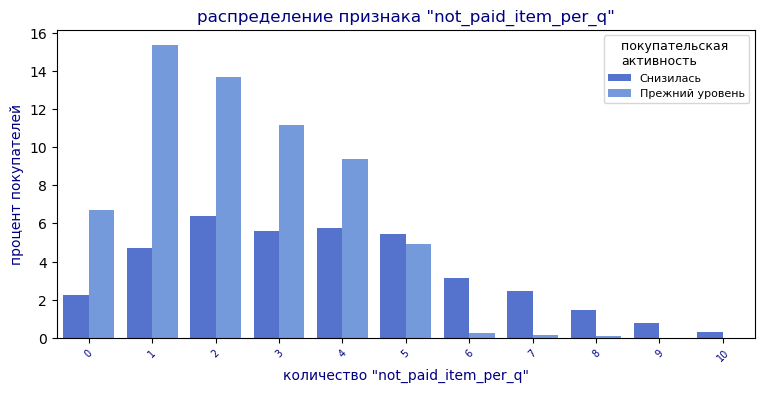

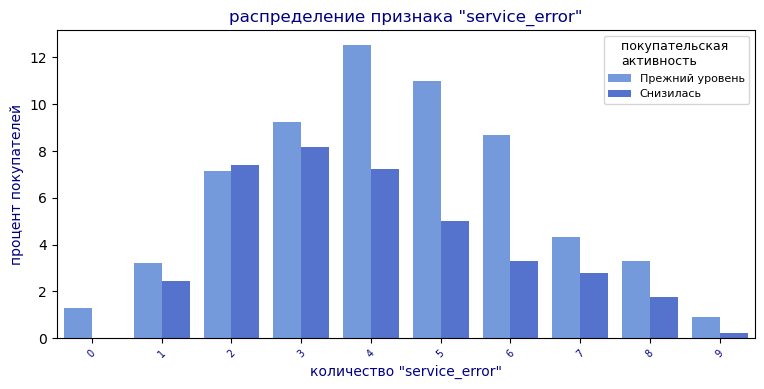

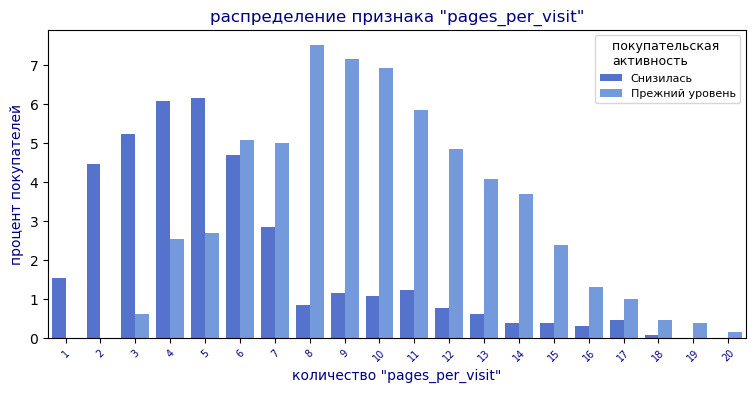

In [38]:
descret_num_cols = ['market_activ_current', 'popular_cat', 'avg_cat_views',\
                    'not_paid_item_per_q', 'service_error', 'pages_per_visit']
for column in descret_num_cols:
    plt.figure(figsize=(9,4))
    descrete_num_feature_plot(market_file, column)

In [39]:
print('Количество данных похожих на аномальные по длительности', market_file.query('duration > 1000')['id'].count())
print('Количество данных похожих на аномальные по неоплаченным покупкам', market_file.query('not_paid_item_per_q > 8')['id'].count())
print('Количество данных похожих на аномальные по количеству страниц за визит', market_file.query('pages_per_visit > 18')['id'].count())

Количество данных похожих на аномальные по длительности 62
Количество данных похожих на аномальные по неоплаченным покупкам 14
Количество данных похожих на аномальные по количеству страниц за визит 7


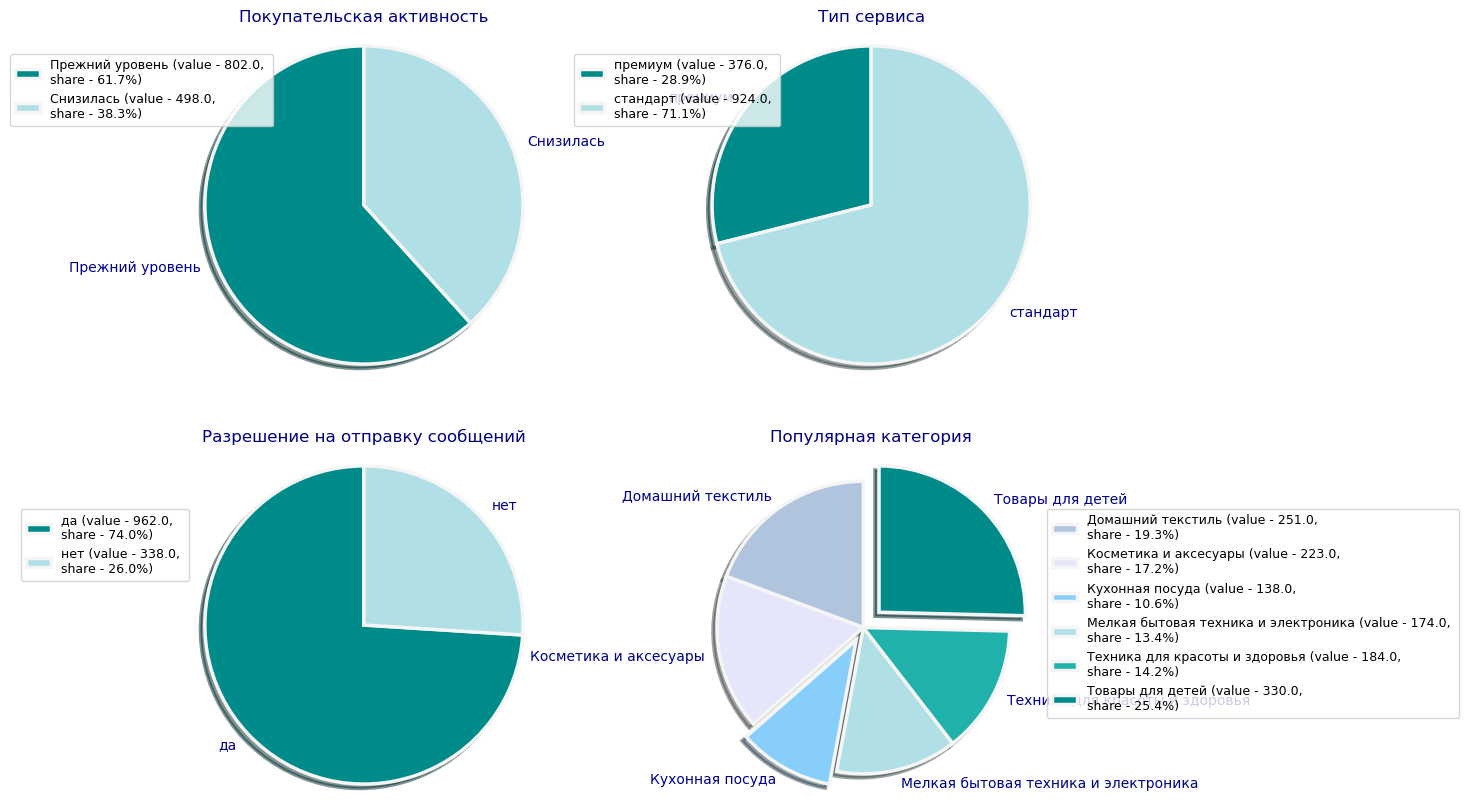

In [40]:
plt.figure(figsize=(12, 10))

#покупательская активность
buying_activ = market_file.groupby('buying_activ', as_index=False).agg({'id':'count'})
ax1 = plt.subplot(2, 2, 1)
labels = list(buying_activ['buying_activ'])
values = buying_activ['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Покупательская активность', color='navy')
plt.axis('equal')

#тип сервиса - service_type
service_type = market_file.groupby('service_type', as_index=False).agg({'id':'count'})
ax2 = plt.subplot(2, 2, 2)
labels = list(service_type['service_type'])
values = service_type['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.6, 0.2, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Тип сервиса', color='navy')
plt.axis('equal')

#разрешение на сообщения allow_message
allow_message = market_file.groupby('allow_message', as_index=False).agg({'id':'count'})
ax3 = plt.subplot(2, 2, 3)
labels = list(allow_message['allow_message'])
values = allow_message['id']
total = sum(values)
colors = ['darkcyan', 'powderblue']
plt.pie(values, colors=colors, labels=labels, \
       wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.1, 0.5, 0, 0.35),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Разрешение на отправку сообщений', color='navy')
plt.axis('equal')

#популярная категория - popular_cat
popular_cat = market_file.groupby('popular_cat', as_index=False).agg({'id':'count'})
ax4 = plt.subplot(2, 2, 4)
labels = list(popular_cat['popular_cat'])
values = popular_cat['id']
total = sum(values)
colors = ['lightsteelblue', 'lavender', 'lightskyblue', 'powderblue', 'lightseagreen', 'darkcyan']
explode = [0,0,0.1,0,0,0.15]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
labels = [f"{n} (value - {v:.1f}, \nshare - {v/total:.1%})" for n,v in zip(labels, values)]
plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels, fontsize=9)
plt.title('Популярная категория', color='navy')
plt.axis('equal')

plt.show();

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><b><i>1. Количественные показатели поведения покупателей на сайте</b></i>:<br>&nbsp;&nbsp;&nbsp;- `market_activ_6mnth`(среднемесячная маркетинговая активность за последние 6 мес.), как и `market_activ_current` (текущая маркетингова активность): у 75% покупателей находится в диапазоне от 3 до 5 раз, медианна 4 контакта.<br>&nbsp;&nbsp;&nbsp;<i>`market_activ_current` принимает всего три значения - 3, 4 и 5. Признак является дискретным количественным</i></i><br>&nbsp;&nbsp;&nbsp;- `duration` (длительность с момента регистрации на сайте): распределение значений показателя нормальное, у 75% покупателей срок регистрации находится в диапазоне от 284 до 912 дней, среднее и медианное количество несильно отличаются и составляют 601 и 606 дней соответственно<br>&nbsp;&nbsp;&nbsp;- `promo_buy`(среднемесячная доля покупок по акции от общего числа покупок за последние 6 мес): на гистограмме видны две четкие области концентрации значений - в диапазоне от 0.1 до 0.4, где сконцентрированно наибольшее количество значений, и в диапазоне от 0.8 до 0.9, средний показатель составляет 0.32.<br>&nbsp;&nbsp;&nbsp;<i>Возможно этот признак в дальнейшем тоже будет иметь смысл сделать категориальным (2 категории: доля покупок по акции менее 0.5 и более 0.5)</i><br>&nbsp;&nbsp;&nbsp;- `avg_cat_views` (среднее количество просмотренных категорий товаров): распределение значений показателя нормальное, у 75% покупателей срок количество просмотренных категорий колблется от 2 до 5, среднее и медианное количество составляет 3 категории товара<br>&nbsp;&nbsp;&nbsp;<i>Этот признак является дискретным количественным</i><br>&nbsp;&nbsp;&nbsp;- `not_paid_item_per_q` (количество неоплаченных товаров в корзине квартал): ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% покупателей количество неоплаченных товаров находится в диапазоне от 1 до 5, среднее и медианное количество 3 товара<br>&nbsp;&nbsp;&nbsp;<i>Этот признак является дискретным количественным</i><br>&nbsp;&nbsp;&nbsp;- `servis_error` (ошибки сервиса): распределение значений показателя нормальное, у 75% покупателей число сбоев находится в диапазоне от 2 до 7 раз, среднее и медианное равны и составляюет 4 сбоя<br>&nbsp;&nbsp;&nbsp;<i>Этот признак является дискретным количественным</i><br>&nbsp;&nbsp;&nbsp;- `pages_per_visit` (число страниц, просмотренных за визит за последние 3 месяца): ассиметричное распределение значений показателя - положительная ассиметрия, у 75% покупателей число страниц находится в диапазоне от 4 до 13 страниц, среднее и медианное равны и составляюет 8 страниц<br>&nbsp;&nbsp;&nbsp;<i>Этот признак является дискретным количественным</i><br><b><i>2. Категорийные показатели поведения покупателей на сайте</b></i><br>&nbsp;&nbsp;&nbsp;- `покупательская активность` - две категории: 'прежний уровень' и 'снизилась', преобладает (61.7%) категория 'прежний уровень'<br>&nbsp;&nbsp;&nbsp;- `тип сервиса`(уровень сервиса) - две категории: 'премиум' и 'стандарт', преобладает (71.1%) категория 'стандарт' <br>&nbsp;&nbsp;&nbsp;- `разрешене на отправку сообщений` - две категории: 'да' и 'нет', преобладает (74.0%) категория 'да'<br>&nbsp;&nbsp;&nbsp;- `популярная категория` - шесть категории, преобладает (25.4%) категория 'товары для детей', наименее популярная - категория 'кухонная посуда' (10.6%)

### Анализ данных о выручке магазина от покупателя

In [44]:
market_money.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

revenue
count   3,900.00
mean    5,025.70
std     1,777.70
min         0.00
12.5%   4,353.95
50%     4,957.50
87.5%   5,755.12
max   106,862.20

<font color='Darkblue'><i>Нулевые значения не являются аномалией и означают, что покупатель не делал покупок водном из анализируемых периодов, а вот расходы на 106,862.2 явно похожи на аномалию. Посмотрим на количество таких транзакций

In [46]:
market_money.query('revenue >= 10000')

id         period    revenue
98  215380  текущий_месяц 106,862.20

In [47]:
market_money.query('id == 215380')

id               period    revenue
96  215380  препредыдущий_месяц   5,051.00
97  215380     предыдущий_месяц   6,077.00
98  215380        текущий_месяц 106,862.20

<font color='Darkblue'><i>Одна транзакцияя покупателя, обычно делающего покупки на 5-6 тыс. Повидимому, в данные зазкралась ошибка, которую надо исправить, удалим из данных аномальные покупки свыше 10,000

In [49]:
market_money = market_money.query('revenue <= 10000')
print('После удаления аномального значения выручки \nмаксимальная сумма выручки за месяц от одного покупателя составляет - ', market_money['revenue'].max())

После удаления аномального значения выручки 
максимальная сумма выручки за месяц от одного покупателя составляет -  7799.4


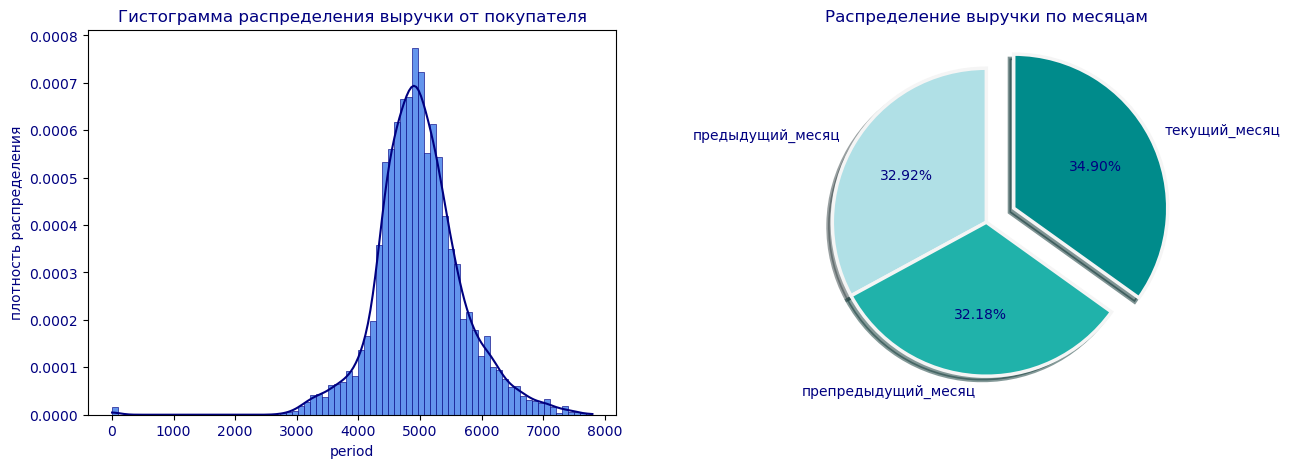

In [50]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=market_money, x='revenue', facecolor = 'cornflowerblue', \
                 edgecolor = 'navy', color='navy',\
                 stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения выручки от покупателя',  fontsize=12, color='navy')
plt.xlabel(col, fontsize=10, color='navy')
plt.ylabel('плотность распределения', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')

plt.subplot(1, 2, 2)
period = market_money.groupby('period', as_index=False).agg({'revenue':'sum'})
labels = list(period['period'])
values = period['revenue']
colors = ['powderblue', 'lightseagreen', 'darkcyan']
explode=[0,0,0.2]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
            wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, autopct='%1.2f%%', startangle=90, \
            textprops={'fontsize': 10, 'color': 'navy'})
plt.title('Распределение выручки по месяцам', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()

<font color='Darkblue'><i>Отберем клиентов с покупательской активностью не менее трёх месяцев

In [52]:
#выберем тех, кто в один из трех последних месяцев не осуществлял покупки
zero_client = market_money.query('revenue == 0')['id'].unique()
print('За последние три месяца сниженная покупательская активность выявлена у {} клиентов, \nсо следующими id:'.format(len(zero_client)), *zero_client, sep=", ")

За последние три месяца сниженная покупательская активность выявлена у 3 клиентов, 
со следующими id:, 215348, 215357, 215359


In [53]:
# исключим клиентов со нулевой покупательской активностью из всех датасетов
market_file = market_file.query('id not in @zero_client')
print('Размер датафрейма market_file', market_file.shape)
market_money = market_money.query('id not in @zero_client')
print('Размер датафрейма market_money', market_money.shape)
market_time =  market_time.query('id not in @zero_client')
print('Размер датафрейма market_time', market_time.shape)
money = money.query('id not in @zero_client')
print('Размер датафрейма market_file', money.shape)

Размер датафрейма market_file (1297, 13)
Размер датафрейма market_money (3890, 3)
Размер датафрейма market_time (2594, 3)
Размер датафрейма market_file (1297, 2)


<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><b><i>1. Количественный показатель расходов покупателей на сайте</b></i>:<br>&nbsp;&nbsp;&nbsp;- `revenue`(выручка от покупателя за период): распределение значений показателя нормально, у 75% покупателей ежемесячные расходы находятся в диапазоне от 4,353.95 до 5,755.12,значение медианы и среднего близки и составляют 4,957.5 и 5,025.7 соответственно<br><b><i>2. Категорийный показатель расходов покупателей на сайте</b></i><br>&nbsp;&nbsp;&nbsp;- `периоды` - три категории: 'препредыдущий месяц', 'предыдущий месяц' и 'текущий месяц', расходы покупателей по месяцам распределены практичечски равномерно.

### Анализ данных о времени, проведенном покупателем на сайте магазина

In [57]:
market_time.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

minutes
count 2,594.00
mean     13.34
std       4.08
min       4.00
12.5%     9.00
50%      13.00
87.5%    19.00
max      23.00

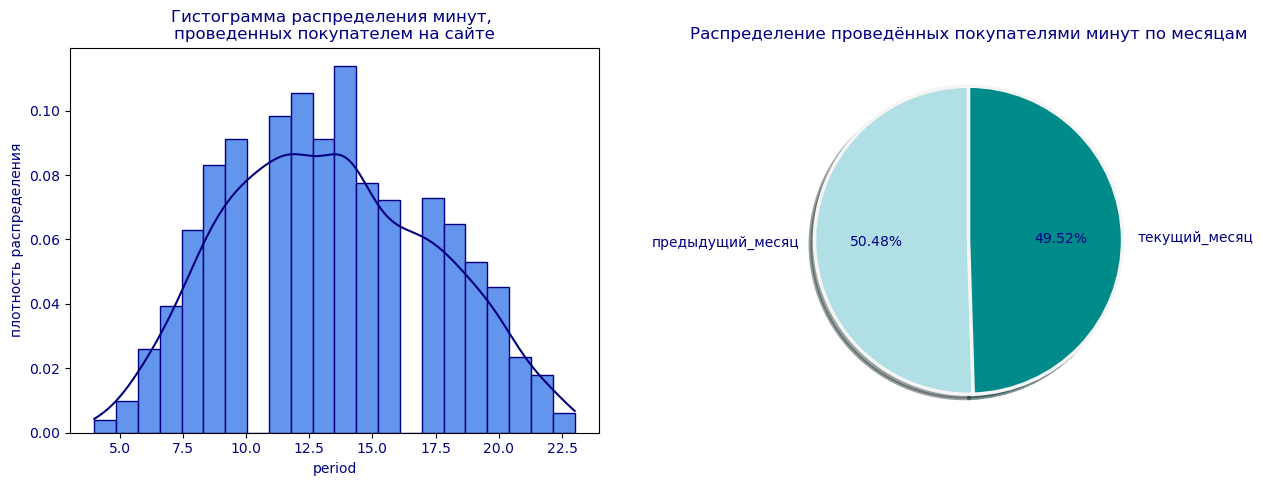

In [58]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=market_time, x='minutes', facecolor = 'cornflowerblue', \
                 edgecolor = 'navy', color='navy',\
                 stat='density', common_norm=False, kde=True)
plt.title('Гистограмма распределения минут, \nпроведенных покупателем на сайте',  fontsize=12, color='navy')
plt.xlabel(col, fontsize=10, color='navy')
plt.ylabel('плотность распределения', fontsize=10, color='navy')
plt.yticks(fontsize=10, color='navy')
plt.xticks(fontsize=10, color='navy')

plt.subplot(1, 2, 2)
period = market_time.groupby('period', as_index=False).agg({'minutes':'sum'})
labels = list(period['period'])
values = period['minutes']
colors = ['powderblue', 'darkcyan']
explode=[0,0]
plt.pie(values, colors=colors, labels=labels, explode=explode, \
            wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, autopct='%1.2f%%', startangle=90, \
            textprops={'fontsize': 10, 'color': 'navy'})
plt.title('Распределение проведённых покупателями минут по месяцам', fontdict = {'fontsize': 12, 'color':'navy'})
plt.show()


<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><b><i>1. Количественный показатель времени, проведенного покупателями на сайте</b></i>:<br>&nbsp;&nbsp;&nbsp;- `minutes`(минуты, проведенные покупателем за месяц): распределение значений показателя нормальное, 75% покупателей проводят на сайте от 9 до 19 минут в месяц, значение медианы и среднего близки и составляют 13.00 и 13.34 соответсвенно<br><b><i>2. Категорийный показатель времени, проведенного покупателями на сайте</b></i><br>&nbsp;&nbsp;&nbsp;- `периоды` - две категории: 'предыдущий месяц' и 'текущий месяц', количество минут, проведенных покупателями на сайте как в предыдущем, так и в текущем практически равно.

### Анализ данных о среднемесячной прибыли от покупателя за последние 3 месяца 

In [62]:
money.drop('id', axis=1).describe(percentiles=[.125, .5, .875])

profit
count 1,297.00
mean      4.00
std       1.01
min       0.86
12.5%     2.84
50%       4.04
87.5%     5.13
max       7.43

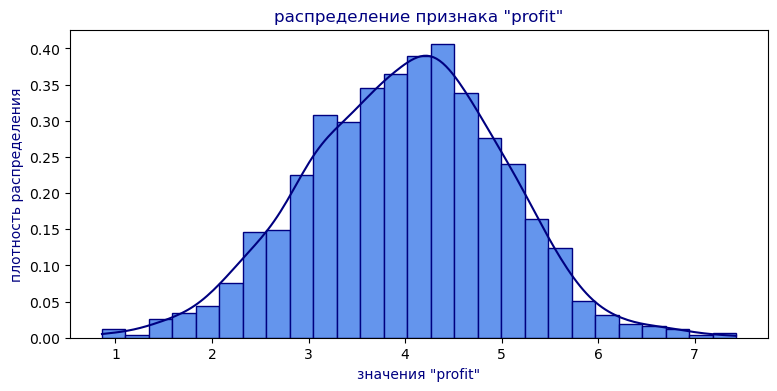

In [63]:
continuous_num_feature_plot(money, 'profit')

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><i> Количественный показатель прибыли от покупателя нормально распределен, 75% покупателей в среднем за месяц приносят прибыль в диапазоне от 2.83 до 5.13. Максимальная среднемесячная прибыль составляет 7.43, среднее и мединное значения среднемесячной прибыли практически равны - 4.00 и 4.04 соответственно.

### Объединение данных

#### Объединение данных о поведении покупателей и выручке, которую они приносят магазину

In [68]:
periods = ['текущий_месяц', 'предыдущий_месяц','препредыдущий_месяц']
for month in periods:
    market_file = market_file.merge(market_money.query('period == @month'),
                                       on='id', how='left', suffixes=('_a', '_b'))
market_file.head()

id buying_activ service_type allow_message  market_activ_6mnth  \
0  215349    Снизилась      премиум            да                4.40   
1  215350    Снизилась     стандарт           нет                4.90   
2  215351    Снизилась     стандарт            да                3.20   
3  215352    Снизилась     стандарт           нет                5.10   
4  215353    Снизилась     стандарт            да                3.30   

   market_activ_current  duration  promo_buy        popular_cat  \
0                     4       819       0.75   Товары для детей   
1                     3       539       0.14  Домашний текстиль   
2                     5       896       0.99   Товары для детей   
3                     3      1064       0.94   Товары для детей   
4                     4       762       0.26  Домашний текстиль   

   avg_cat_views  not_paid_item_per_q  service_error  pages_per_visit  \
0              4                    4              2                5   
1              5                    2              1                5   
2              5                    0              6                4   
3              3                    2              3                2   
4              4                    1              1                4   

        period_a  revenue_a          period_b  revenue_b               period  \
0  текущий_месяц   4,971.60  предыдущий_месяц   5,216.00  препредыдущий_месяц   
1  текущий_месяц   5,058.40  предыдущий_месяц   5,457.50  препредыдущий_месяц   
2  текущий_месяц   6,610.40  предыдущий_месяц   6,158.00  препредыдущий_месяц   
3  текущий_месяц   5,872.50  предыдущий_месяц   5,807.50  препредыдущий_месяц   
4  текущий_месяц   5,388.50  предыдущий_месяц   4,738.50  препредыдущий_месяц   

   revenue  
0 4,472.00  
1 4,826.00  
2 4,793.00  
3 4,594.00  
4 5,124.00

In [69]:
# удалим ненужные колонки с периодами и переименуем колонки с выручкой
market_file = market_file.drop(['period_a', 'period_b', 'period'], axis=1)
market_file = market_file.rename(columns={'revenue_a':'revenue_current', 'revenue_b':'revenue_pre', 'revenue':'revenue_prepre'})
# проверим корректность присоедининения таблиц и переименования столбцов
print(market_file.query('id == 215349')[['id', 'revenue_current', 'revenue_pre', 'revenue_prepre']].T)
market_money.query('id == 215349')

                         0
id              215,349.00
revenue_current   4,971.60
revenue_pre       5,216.00
revenue_prepre    4,472.00


id               period  revenue
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60
5  215349     предыдущий_месяц 5,216.00

#### Объединение данных о поведении покупателей и времни, которое покупатели проводят на сайте

In [71]:
periods_min = ['текущий_месяц', 'предыдущий_месяц']
for month in periods_min:
    market_file = market_file.merge(market_time.query('period == @month'),
                                       on='id', how='left', suffixes=('_с', '_d'))
market_file.columns.values

array(['id', 'buying_activ', 'service_type', 'allow_message',
       'market_activ_6mnth', 'market_activ_current', 'duration',
       'promo_buy', 'popular_cat', 'avg_cat_views', 'not_paid_item_per_q',
       'service_error', 'pages_per_visit', 'revenue_current',
       'revenue_pre', 'revenue_prepre', 'period_с', 'minutes_с',
       'period_d', 'minutes_d'], dtype=object)

In [72]:
# удалим ненужные колонки с периодами
market_file = market_file.drop(['period_с', 'period_d'], axis=1)
market_file = market_file.rename(columns={'minutes_с':'minutes_current', 'minutes_d':'minutes_pre'})
# проверим корректность присоедининения таблиц и переименования столбцов
print(market_file.query('id == 215349')[['id', 'minutes_current', 'minutes_pre']].T)
market_time.query('id == 215349')

                      0
id               215349
minutes_current      10
minutes_pre          12


id            period  minutes
2  215349     текущий_месяц       10
3  215349  предыдущий_месяц       12

### Анализ объединенных данных

#### Анализ распределения количественных признаков в разрезе типов активности покупателей

In [75]:
# соформируем функцию для визуализации распределения непрерывных количественных признаокв 
# в разрезе категорий целевого признака - покупательская активность
def continuous_num_feature_plot_2(df, col):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col, hue='buying_activ', palette ={'Снизилась': 'navy', 'Прежний уровень': 'cornflowerblue'}, \
                 edgecolor = 'navy', \
                 stat='density', common_norm=False, kde=True)
    plt.title(f'Гистограмма распределения \nдля "{col}" по типам активности',  fontsize=12, color='navy')
    plt.xlabel(col, fontsize=10, color='navy')
    plt.ylabel('плотность распределения', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='buying_activ', y=col, hue='buying_activ', 
                palette ={'Снизилась': 'lightsteelblue', 'Прежний уровень': 'cornflowerblue'}, fill=True, gap=.1, width=.75, \
                linecolor='navy')
    plt.title(f'Диаграмма размаха \nдля "{col}" по типам активности',  fontsize=12, color='navy')
    plt.ylabel(col, fontsize=10, color='navy')
    plt.xlabel('buying_activ', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    plt.show()

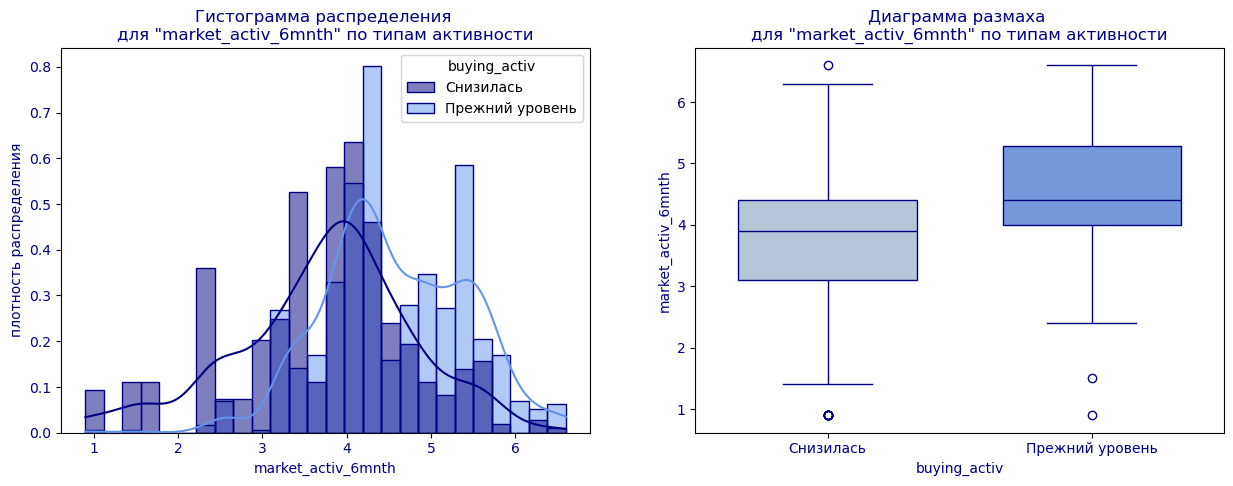

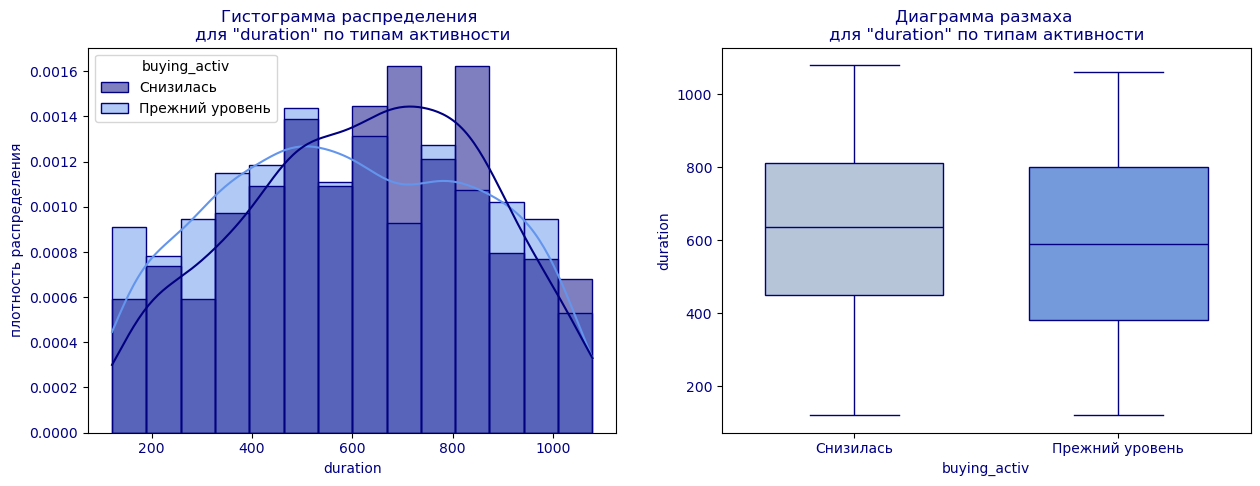

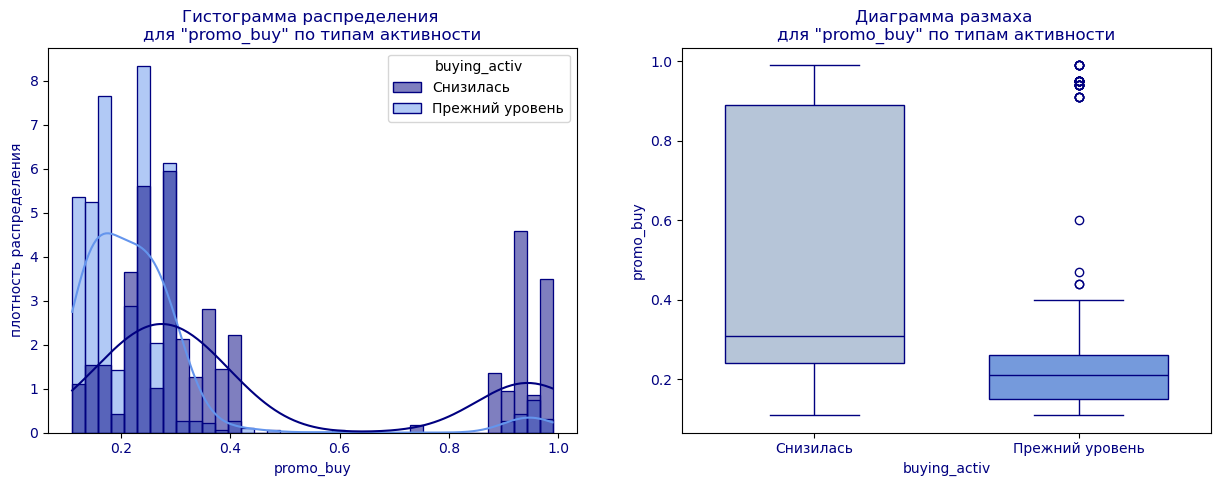

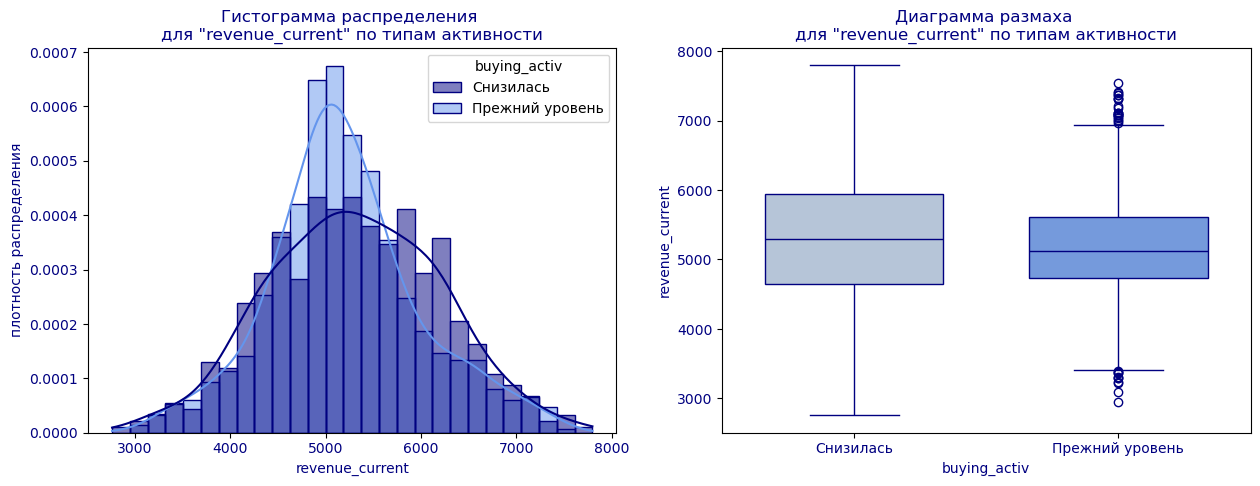

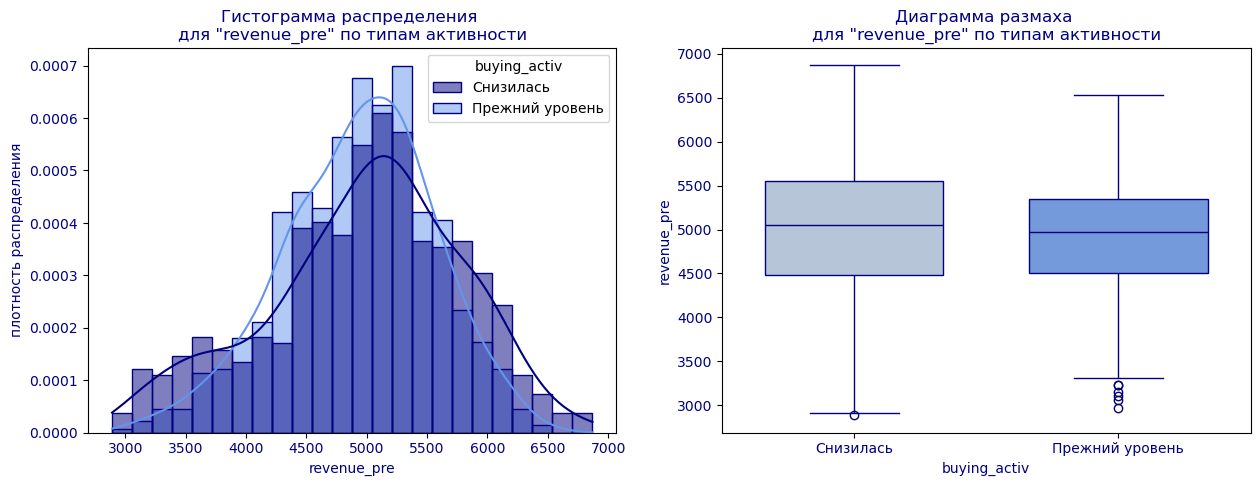

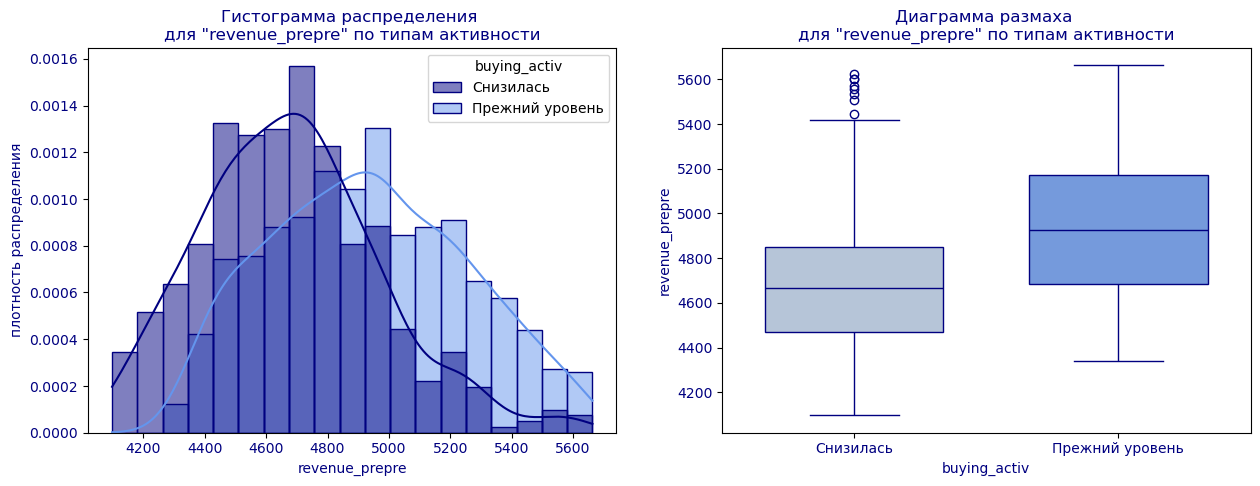

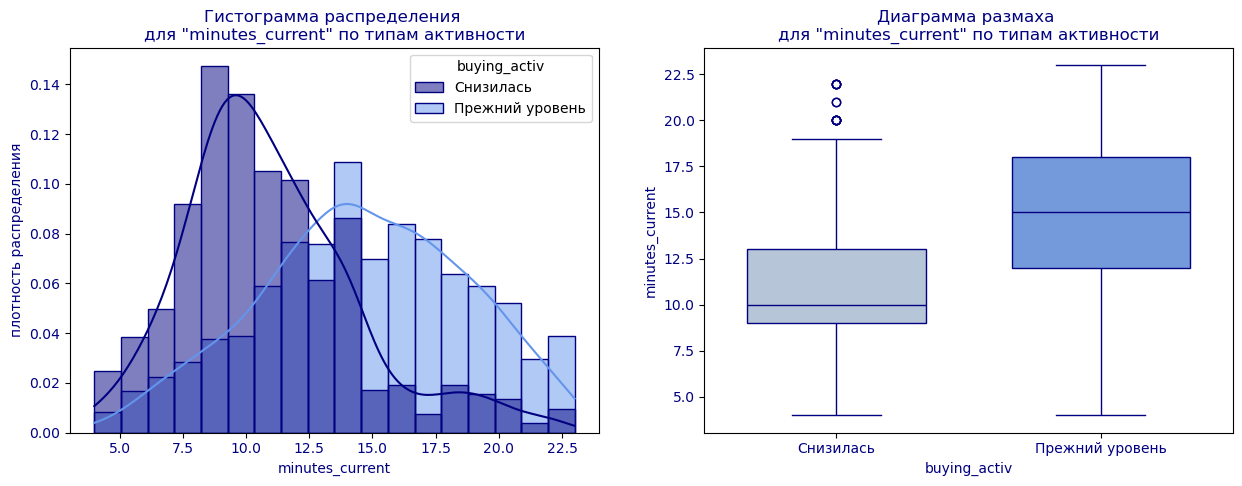

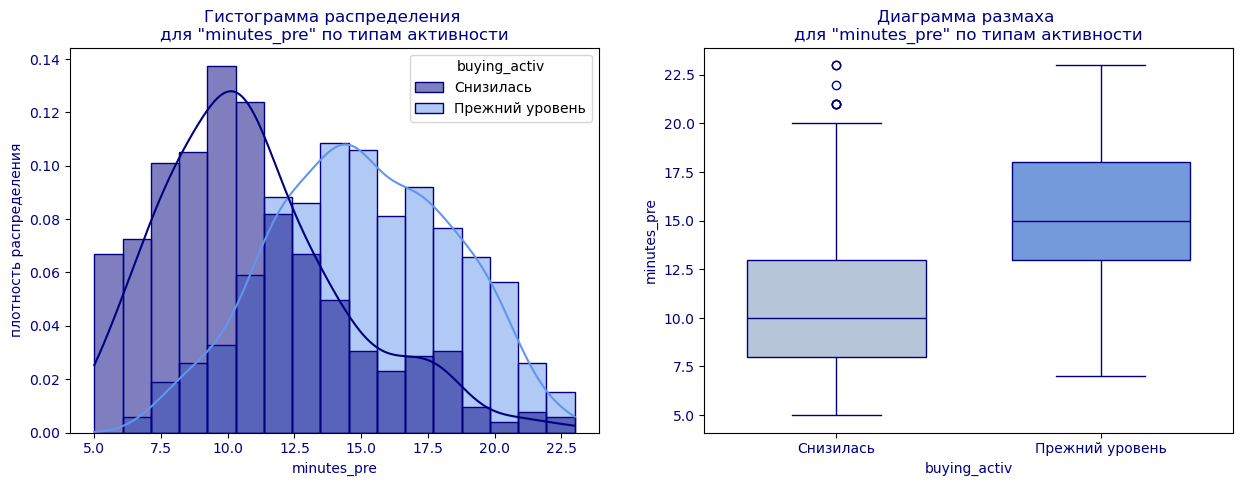

In [76]:
continuous_num_cols_2 = continuous_num_cols + \
                    ['revenue_current', 'revenue_pre', 'revenue_prepre', 'minutes_current', 'minutes_pre']
for num_col in continuous_num_cols_2:
    continuous_num_feature_plot_2(market_file, num_col)

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><i><u>Анализ графиков показывает, что:</i></u><br><b>1. у покупателей с прежним уровнем покупательской активности выше уровень:</b><br> - маркетинговых коммуникаций за последние 6 мес, <br>- выручка за текущий месяц (при этом за прошлый и предпредыдущий - одинакова для обеих групп), <br>- время, проведенное на сайте как в текущем, так и в прошлом месяце,<br><b>2. у покупателей со сниженной покупательской активностью выше уровень</b><br>- доли акционных покупок <br>- у этой группы также выше и количество неоплаченных товаров в корзине<br>3. длительность с момента регистрации на сайте у покупателей обеих групп распределена в примерно в одинаковых диапазонах, с небольшим преимуществом в длительности по группе, чья покупательская активность снизилась

#### Анализ распределения категорийных признаков в разрезе типов активности покупателей

In [80]:
# соформируем функцию для визуализации распределения категорийных признаокв 
# в разрезе категорий целевого признака - покупательская активность
def cat_feature_plot(df, col):
    labels = list(df[col].unique())
    values_a = df[df['buying_activ'] == 'Снизилась'].groupby(col)['id'].count()
    values_b = df[df['buying_activ'] == 'Прежний уровень'].groupby(col)['id'].count()
    total_a = sum(values_a)
    total_b = sum(values_b)
    labels_a = [f"{n} (value - {v:.1f}, \nshare - {v/total_a:.1%})" for n,v in zip(labels, values_a)]
    labels_b = [f"{n} (value - {v:.1f}, \nshare - {v/total_b:.1%})" for n,v in zip(labels, values_b)]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.pie(values_a, colors=sns.color_palette('Blues_r'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" для покупателей \nсо сниженной покупательской активностью',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_a, fontsize=9)
    plt.subplot(1, 2, 2)
    plt.pie(values_b, colors=sns.color_palette('vlag'), \
        wedgeprops={'linewidth':2.5, 'edgecolor':'whitesmoke'}, shadow=True, startangle=90, \
        textprops={'fontsize': 10, 'color': 'darkblue'})
    plt.title(f'Распределение "{col}" для покупателей \nс прежней покупательской активностью',  fontsize=12, color='navy')
    plt.legend(bbox_to_anchor = (0.9, 0.45, 0.1, 0.4),
                loc = 'best', labels = labels_b, fontsize=9)
    plt.show()

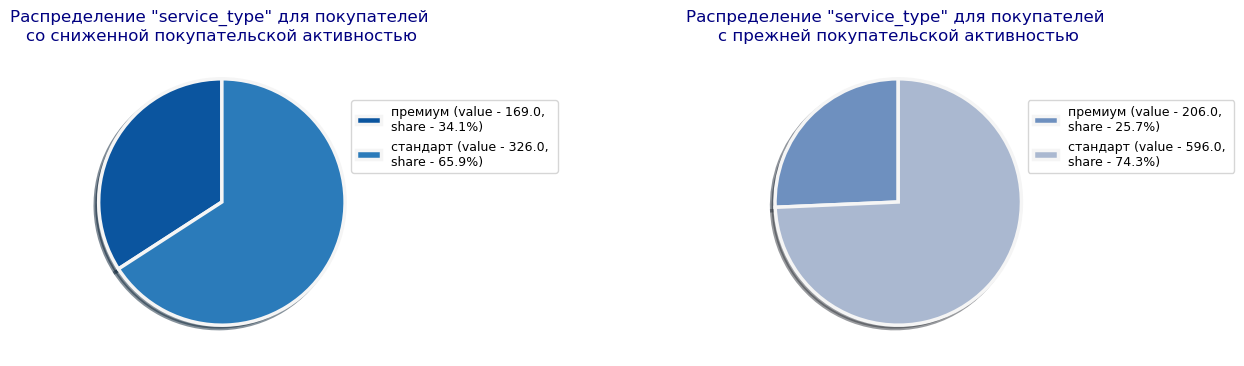

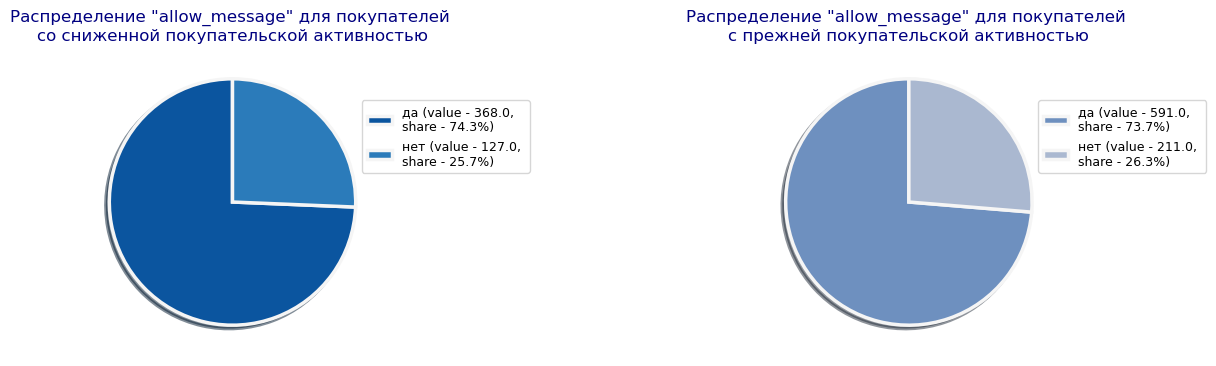

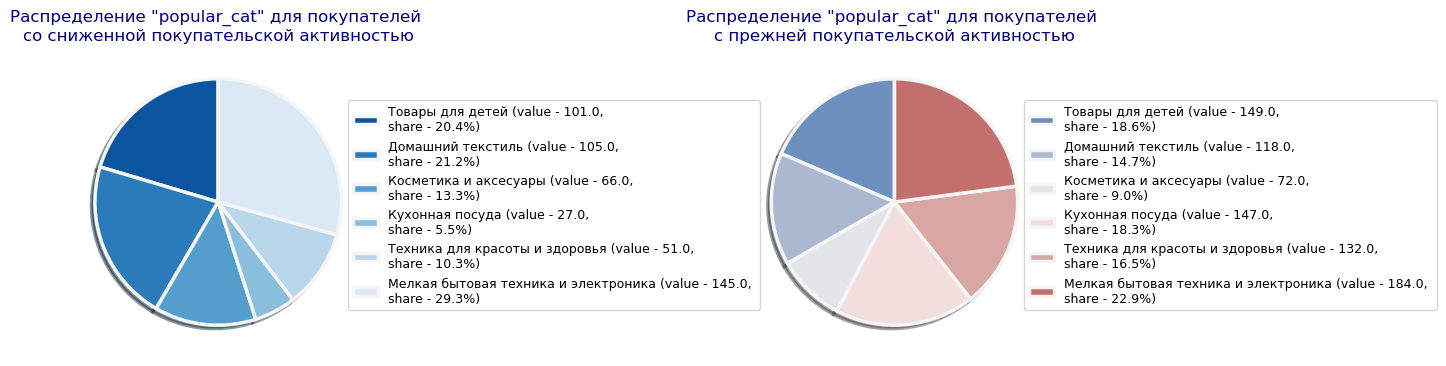

In [81]:
cat_col = market_file.drop(['id', 'buying_activ'], axis=1).select_dtypes(include='object').columns.to_list()
for cat_col in cat_col:
    cat_feature_plot(market_file, cat_col)

<font color='Darkblue'><b><i>Комментарий

<font color='Darkblue'><i><u>Анализ графиков показывает, что:</u><br>структура преобладающего целевого признака по категориям идентична: в обеих покупательских группах преобладает стандартный уровень сервиса, согласие на отправку сообщений и наиболее популярная товарная категория (мелкая бытовая техника).</i><br>Справедливости ради, необходимо заметить, что немного разнятся предпочтения по категориям товаров (за исключением лидера - мелкой бытововй техники и электроники)

### Корреляционный анализ

In [85]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['market_activ_6mnth', 'promo_buy', 'avg_cat_views', \
                 'revenue_current', 'revenue_pre', 'revenue_prepre']

In [86]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(market_file.drop('id', axis=1), interval_cols=interval_cols) 

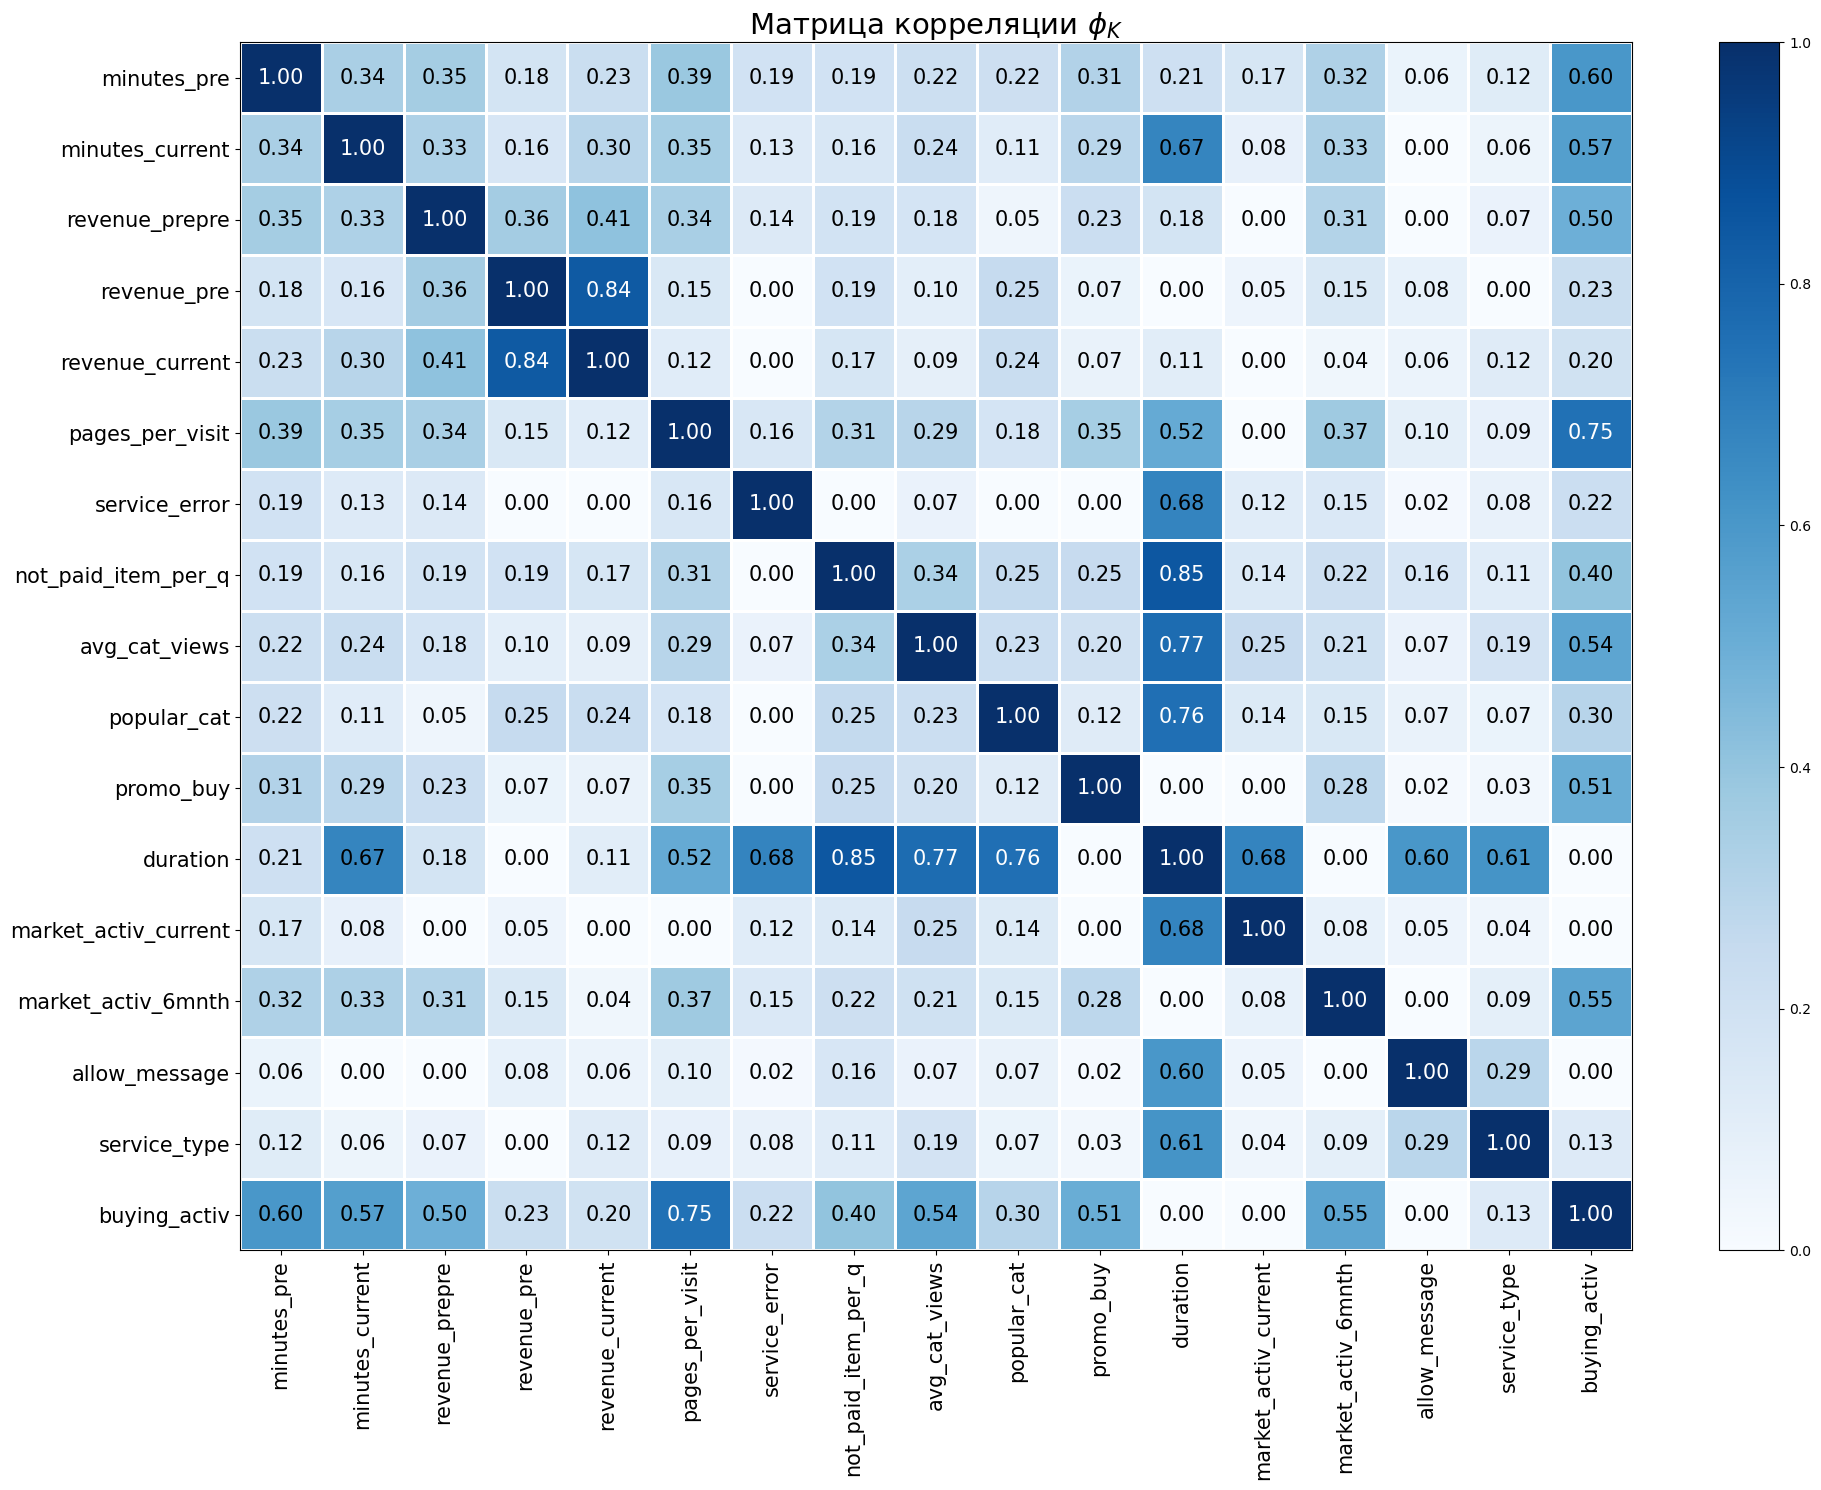

In [87]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

<font color='Darkblue'><i>Есть две пары признаков с высокой корреляцией:<br>- `duration`(срок с момента регистрации на сайте) и `not_paid_item_per_q` (общее число неоплаченных товаров в корзине за последние 3 месяца)<br>- `revenue_current` и `revenue_per` - выручка за текущий и прошлый месяца<br>Удалим из датасета признаки, которые меньше влияют на покупательскую активность: `duration` из первой пары и `revenue_current` из второй.

In [89]:
market = market_file.drop(['duration','revenue_current'], axis=1)

### Резюме анализа данных

<font color='Darkblue'><b><i>1. Количественные показатели </b></i>:<br>&nbsp;&nbsp;&nbsp;- `market_activ_6mnth`(среднемесячная маркетинговая активность за последние 6 мес.), как и `market_activ_current` (текущая маркетинговая активность): у 75% покупателей находится в диапазоне от 3 до 5 раз, медианна 4 контакта.<br>&nbsp;&nbsp;&nbsp;- `duration` (длительность с момента регистрации на сайте): распределение значений показателя нормальное, у 75% покупателей срок регистрации находится в диапазоне от 284 до 912 дней, среднее и медианное количество несильно отличаются и составляют 601 и 606 дней соответственно<br>&nbsp;&nbsp;&nbsp;- `promo_buy`(среднемесячная доля покупок по акции от общего числа покупок за последние 6 мес): на гистограмме видны две четкие области концентрации значений - в диапазоне от 0.1 до 0.4, где сконцентрированно наибольшее количество значений, и в диапазоне от 0.8 до 0.9, средний показатель составляет 0.32.<br>&nbsp;&nbsp;&nbsp;- `avg_cat_views` (среднее количество просмотренных категорий товаров): распределение значений показателя нормальное, у 75% покупателей количество просмотренных категорий колблется от 2 до 5, среднее и медианное количество составляет 3 категории товара<br>&nbsp;&nbsp;&nbsp;- `not_paid_item_per_q` (количество неоплаченных товаров в корзине за квартал): ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% покупателей количество неоплаченных товаров находится в диапазоне от 1 до 5, среднее и медианное количество - 3 товара<br>&nbsp;&nbsp;&nbsp;- `servis_error` (ошибки сервиса): распределение значений показателя нормальное, у 75% покупателей число сбоев находится в диапазоне от 2 до 7 раз, среднее и медианное значения равны и составляют 4 сбоя<br>&nbsp;&nbsp;&nbsp;- `pages_per_visit` (число страниц, просмотренных за визит за последние 3 месяца): ассиметричное распределение значений показателя - положительная ассиметрия, у 75% покупателей число страниц находится в диапазоне от 4 до 13 страниц, среднее и медианное значения равны и составляют 8 страниц<br>&nbsp;&nbsp;&nbsp;- `revenue`(выручка от покупателя за период): распределение значений показателя нормально, у 75% покупателей ежемесячные расходы находятся в диапазоне от 4,353.95 до 5,755.12, значения медианы и среднего близки и составляют 4,957.5 и 5,025.7 соответственно<br>&nbsp;&nbsp;&nbsp;- `minutes`(минуты, проведенные покупателем за месяц): распределение значений показателя нормальное, 75% покупателей проводят на сайте от 9 до 19 минут в месяц, значения медианы и среднего близки и составляют 13.00 и 13.34 соответственно<br>&nbsp;&nbsp;&nbsp;- `profit` (прибыль от покупателя) нормально распределен, 75% покупателей в среднем за месяц приносят прибыль в диапазоне от 2.83 до 5.13. Максимальная среднемесячная прибыль составляет 7.43, среднее и медианное значения среднемесячной прибыли практически равны - 4.00 и 4.04 соответственно.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<i><u>Количественный признак `promo_buy` - в рамках разработки модели прогнозирования в силу своей особенности распределения целесообразно преобразовать в категорийный

<font color='Darkblue'><b><i>2. Категорийные показатели </b></i><br>&nbsp;&nbsp;&nbsp;- `покупательская активность` (целевой признак) - две категории: 'прежний уровень' и 'снизилась', преобладает (61.7%) категория 'прежний уровень'<br>&nbsp;&nbsp;&nbsp;- `тип сервиса`(уровень сервиса) - две категории: 'премиум' и 'стандарт', преобладает (71.1%) категория 'стандарт' <br>&nbsp;&nbsp;&nbsp;- `разрешене на отправку сообщений` - две категории: 'да' и 'нет', преобладает (74.0%) категория 'да'<br>&nbsp;&nbsp;&nbsp;- `популярная категория` - шесть категорий, преобладает (25.4%) категория 'товары для детей', наименее популярная - категория 'кухонная посуда' (10.6%)<br>&nbsp;&nbsp;&nbsp;- `периоды` - три категории: 'препредыдущий месяц', 'предыдущий месяц' и 'текущий месяц', расходы покупателей по месяцам распределены практичечски равномерно.<br>&nbsp;&nbsp;&nbsp;- `периоды` - две категории: 'предыдущий месяц' и 'текущий месяц', количество минут, проведенных покупателями на сайте как в предыдущем, так и в текущем практически равно.

<font color='Darkblue'><i><b>3. Количественные и категорийные показатели в разрезе покупательской активности</i></b><br>&nbsp;&nbsp;&nbsp;<b>a) у покупателей с прежним уровнем покупательской активности выше уровень:</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- маркетинговых коммуникаций за последние 6 мес, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- среднее количество просмотренных категорий товаров, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- количество просмотренных страниц за визит, <br>- выручка за текущий месяц (при этом за прошлый и предпредыдущий - одинакова для обеих групп), <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- время, проведенное на сайте как в текущем, так и в прошлом месяце, <br>- количество сбоев сервиса также превалирует у этой группы (при этом медиана - 4 сбоя - на одном уровне у обеих групп)<br><b>&nbsp;&nbsp;&nbsp;b) у покупателей со сниженной покупательской активностью выше уровень</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- доли акционных покупок <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- количества неоплаченных товаров в корзине<br>&nbsp;&nbsp;&nbsp;<b>c) примерно в одинаковых диапазонах </b>находится длительность с момента регистрации на сайте у покупателей обеих групп распределена примерно в одинаковых диапазонах, с небольшим преимуществом в длительности по группе, чья покупательская активность снизилась<br>&nbsp;&nbsp;&nbsp;<b>d) структура преобладающего целевого признака по категориям идентична: в обеих покупательских группах преобладает стандартный уровень сервиса, согласие на отправку сообщений и наиболее популярная товарная категория (мелкая бытовая техника)

<font color='Darkblue'><b>4. В результате корреляционного анализа </b>объединенных данных выявлен высокий уровень корреляции между данными о выручке в текущем и предыдущем месяце, а также между данными о периоде с момента регистрации на сайте и количестве неоплаченных покупок в корзине. Для избежания влияния мультиколлинеарности, данные о выручке за текущий месяц и о периоде с момента регистрации были удалены

## Определение наилучшей модели для прогноза покупательской активности

<font color='Darkblue'><i>Перед началом подготовки данных для дальнейшего кодирования, изменим показатель 'promo_buy' на категориальный. Как раннее при анализе распределения признака было отмечено, что на гистограмме распределения признака четко прослеживается два пика, т.е. перед нами ярковыраженное бимодальное распределение с границей межде ними в районе значения 0.5. В связи с этим преобразуем этот признак в категорийный с порогом 0.5: все что выше порога 0.5 - 1, ниже порога - 0

In [97]:
# изменим показатель 'promo_buy' на категориальный: все что выше порога 0.5 - 1, ниже порога - 0
market['promo_'] = market['promo_buy'].apply(lambda x : 1 if x>0.5 else 0)
market['promo_'].unique()

array([1, 0], dtype=int64)

### Разбиение на выборки, кодирование целевого признака

In [99]:
# определяем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# делим данные на входные и целевые
X = market.drop(['buying_activ', 'id', 'promo_buy'], axis=1)
y = market['buying_activ']

# делим данные на тренировочные и тестовые
# используем константы с размером тестовой выборки и random_state
# выполняем стратификацию по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

In [100]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)
X.columns.to_list()

Размер тренировочной выборки: (972, 14)
Размер тестовой выборки: (325, 14)


['service_type',
 'allow_message',
 'market_activ_6mnth',
 'market_activ_current',
 'popular_cat',
 'avg_cat_views',
 'not_paid_item_per_q',
 'service_error',
 'pages_per_visit',
 'revenue_pre',
 'revenue_prepre',
 'minutes_current',
 'minutes_pre',
 'promo_']

In [101]:
# создаём списки с названиями признаков для различных методов подготовки данных
ohe_columns = ['popular_cat']
ord_columns = ['service_type', 'allow_message', 'promo_']
num_columns = ['market_activ_6mnth', 'market_activ_current', 'avg_cat_views', 'not_paid_item_per_q', 
               'service_error', 'pages_per_visit', 'revenue_pre', 'revenue_prepre', 'minutes_current', 'minutes_pre']

In [102]:
# кодирование целевого признака
#создаем экземпляр класса LabelEncoder
label_encoder = LabelEncoder()
# обучаем и кодируем тренировочную выборку
y_train = label_encoder.fit_transform(y_train)
# кодируем тестовую выборку
y_test = label_encoder.transform(y_test)

In [103]:
y_1 = y_train.sum() + y_test.sum()
if y_1 < 500:
    print('Класс_1 присвоен категории покупателей со сниженной покупательской активностью')
else:
    print('Класс_1 присвоен категории покупателей с прежним уровнем покупательской активности')

Класс_1 присвоен категории покупателей со сниженной покупательской активностью


### Создание пайплайнов для подготовки данных, определения лучшей комбинации модели и гиперпараметров

In [105]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [106]:
# создаем параметры для перебора методов подготовки данных и поиска оптимальной модели 
param_grid = {
    #зададим варианты масштабирования для GridSearchCV
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler(), 
        RobustScaler(), 
        'passthrough'
    ],
    # зададим варианты моделей
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE), 
               KNeighborsClassifier(), 
               SVC(random_state=RANDOM_STATE, probability=True), 
               LogisticRegression(random_state=RANDOM_STATE)]
}

In [107]:
#для перебора гиперпараметров моделей создадим список словарей,
# в котором каждый словарь — это модель с гиперпараметрами и методами подготовки данных

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
] 

### Обучение и выбор наилучшей модели

<font color='Darkblue'><i>Как было выявлено раннее, в данных целевого параметра - покупательская активность -  есть преобладание категории 'прежний уровень' (61.7%), поэтому для оценки качества модели будем использовать метрику ROC_AUC, которая не зависит от дисбаланса классов и не зависит от значения порога отнесения к тому или иному классу.

#### Выбор наилучшей модели путем перебора методов масштабирования и типов моделей

In [111]:
# для подбора гиперпараметров будем использовать инструмент GridSearchCV, в ктором 
# в качестве модели укажем финальный пайплайн
# в качестве гиперпараметров словарь гиперпараметров с методами подготовки данных и поиска оптимальной модели
# в качестве метрики модели - roc-auc
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)
# обучим модель и посмотрим метрику на тренировочной выборке
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:', round(grid.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_cat']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                    

<font color='Darkblue'><i>Таким образом, перебор моделей и методов подготовки данных с помощью GridSearchCV показал, что <br>- наилучшей моделью является <b>модель `SVC`, с использованием масштабирования методом `StandardScaller()`.</b><br> При такой конфигурации метрика <b>ROC-AUC на тренировочных составляет 0.9137</b>

In [113]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.predict(X_train)
dummy_clf_probas = dummy_clf.predict_proba(X_test)[:,1]

# Рассчитываем и выводим метрику ROC-AUC
dummy_roc_auc = roc_auc_score(y_test, dummy_clf_probas)
print('Метрика ROC-AUC для константной модели:', round(dummy_roc_auc, 4))

Метрика ROC-AUC для константной модели: 0.5


#### Выбор наилучшей модели путем перебора моделей, их гиперпараметров и методов подготовки данных

In [115]:
# для подбора гиперпараметров будем использовать инструмент RindomizedSearchCV, в котором 
# в качестве модели укажем финальный пайплайн
# в качестве гиперпараметров моделей словарей гиперпараметров моделей 
# в качестве метрики модели - roc-auc
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring = 'roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

# обучим модель и посмотрим метрику на тренировочной выборке
randomized_search.fit(X_train, y_train) 

print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('\n\nМетрика ROC-AUC для лучшей модели:', round(randomized_search.best_score_, 4)) 

# посмотрим метрику лучшей модели на тестовой выборке
#y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
#print('\nМетрика ROC-AUC на тестовой выборке', round(roc_auc_score(y_test, y_test_pred_proba), 4))


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_cat']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                   

<font color='Darkblue'><i>Таким образом, перебор моделей, их гиперпараметров и методов подготовки данных с помощью RandomizedSearchCV показал те же результаты: <br>- наилучшей моделью является <b>модель `SVC()` и масштабированием `StandardScaler()`</b><br> При такой конфигурации метрика <b>ROC-AUC на тренировочных составляет 0.9137</b>

In [117]:
print('Посморим параметры лучшей модели, определенной поиском GridSearchCV с перебором моделей и методов масштабирования')
print(grid.best_params_,'\nМетрика ROC_AUC на тренировочной выборке -', round(grid.best_score_, 4)) 

Посморим параметры лучшей модели, определенной поиском GridSearchCV с перебором моделей и методов масштабирования
{'models': SVC(probability=True, random_state=42), 'preprocessor__num': StandardScaler()} 
Метрика ROC_AUC на тренировочной выборке - 0.9137


In [118]:
print('Посморим параметры лучшей модели, определенной поиском RandomizedSearchCV \nс перебором методов маштабирования, моделей и их гиперпараметров')
print(randomized_search.best_params_,'\nМетрика ROC_AUC на тренировочной выборке -', round(randomized_search.best_score_, 4)) 

Посморим параметры лучшей модели, определенной поиском RandomizedSearchCV 
с перебором методов маштабирования, моделей и их гиперпараметров
{'preprocessor__num': StandardScaler(), 'models': SVC(probability=True, random_state=42)} 
Метрика ROC_AUC на тренировочной выборке - 0.9137


<font color='Darkblue'><i><b>Оба подбора дали идентичный результат. Оценим ROC-AUC на лучшей модели для тестовых данных

In [120]:
# посмотрим метрику лучшей модели на тестовой выборке
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, y_test_pred_proba), 4))

Метрика ROC-AUC на тестовой выборке: 0.9134


### Резюме

<font color='Darkblue'> В результате перебора моделей, их гиперпараметров и методов подготовки данных показал, что: <br>- наилучшей моделью является <b>модель опорных векторов - `SVC()` с масштабированием методом `StandardScaler()`</b><br> При такой конфигурации метрика <b>ROC-AUC на тренировочных составляет 0.9137, на тестовых - 0.9134

## Анализ важности признаков

<font color='Darkblue'>Оценку вклада признака в каждый прогноз показывают значения Шепли.<br> Оценим вклад признаков в предсказание модели с помощью визуализации, построим <br>1. диаграмму shap.plots.beeswarm -  отображает вклад каждого признака в классификацию всех наблюдений<br>2. диаграммау shap.plots.bar, которая отражает общий вклад признаков в прогнозы модели, показывает средние SHAP-значения признака по всем наблюдениям

In [125]:
#кодируем признаки выбранным наиболее подходящим кодировщиком
X_coded = grid.best_estimator_['preprocessor'].fit_transform(X_train)
# обучаем определенную как лучшая модель на закодированных входных признаках
model = grid.best_estimator_['models'].fit(X_coded, y_train)
# формируем список признаков
features_names = grid.best_estimator_[:-1].get_feature_names_out()
# сформируем новый датафрейм с закодированными данными тренировочной выборки
X_train_coded = pd.DataFrame(X_coded, columns = features_names)

In [126]:
background = shap.maskers.Independent(X_coded, max_samples=50)

explainer = shap.Explainer(grid.best_estimator_['models'].predict, background, feature_names=features_names)
explanation = explainer(X_coded)

PermutationExplainer explainer: 973it [29:09,  1.80s/it]                           


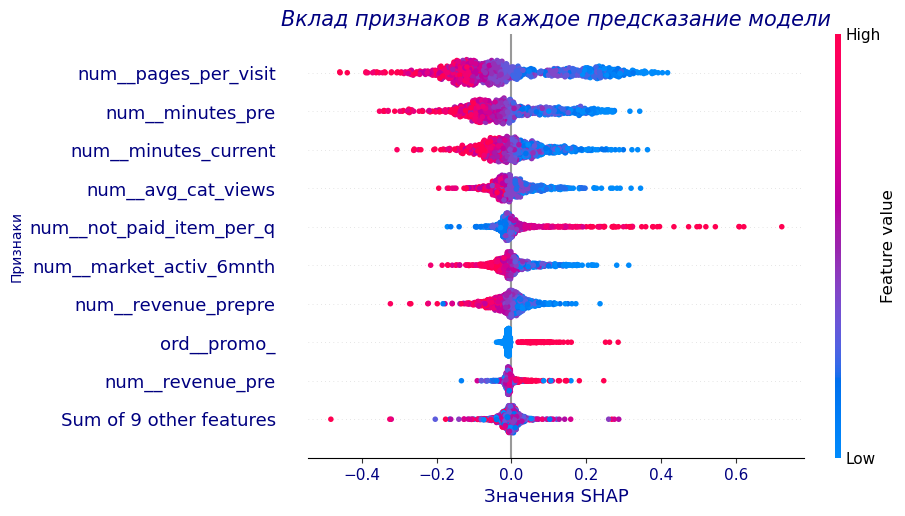

In [127]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 1, 1)
shap.plots.beeswarm(explanation, show=False)
plt.title('Вклад признаков в каждое предсказание модели', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

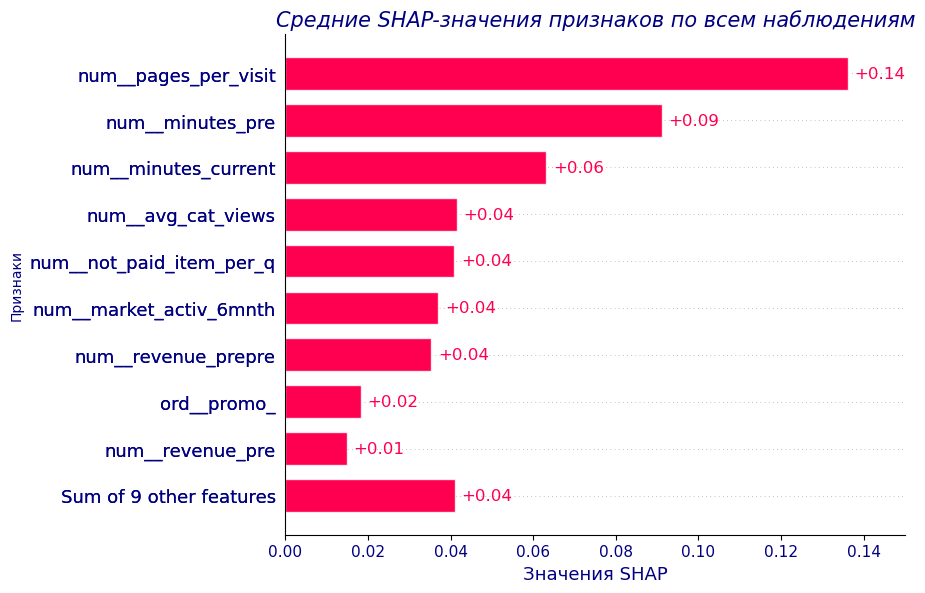

In [128]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
shap.plots.bar(explanation, show=False)
plt.title('Средние SHAP-значения признаков по всем наблюдениям', color='navy', fontsize = 15, fontstyle='italic')
plt.ylabel('Признаки', color = 'navy')
plt.yticks(color = 'navy')
plt.xticks(color = 'navy')
plt.xlabel('Значения SHAP', color = 'navy')
plt.show()

### Резюме

<font color='Darkblue'><b>Наиболее значимыми признаками модели</b> являются- <b>`pages_per_visit`</b> - количество просмотренных страниц: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`minutes_pre` и `minutes_current`</b> - количество минут, проведенных покупателем на сайте: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`avg_cat_viewse`</b> - среднее количество просмотренных категорий: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`not_paid_item_per_q`</b> - количество неоплаченных товаров в корзине: прямая зависимость - значение выше - вероятность принадлежности к классу 1 выше<br>- <b>`revenue_prepre`</b> - выручка от покупателя за пердыдущий месяц: значение выше - вероятность принадлежности к классу 1 ниже<<br>- <b>`market_activ_6mnth`</b> - среднее количество маркетинговых контактов за последние 6 мес: значение выше - вероятность принадлежности к классу 1 ниже<br><b><i>Прямая зависимость: рост значения признака приводит к росту вероятности принадлежности объекта к классу 1 наблюдается у признаков `not_paid_item` (неоплаченные товары в корзине) и `promo_1` (доля товаров, приобретенных по скидке, более 50%)</b></i><br><i><u>На основе наиболее значимых признаков можно сделать сегментацию покупателей, которая позволит сформировать более четкое понимание маркеров снижения покупательской активности и шагов, направленных на его предотвращение 

## Сегментация покупателей

### Пороговые значения наиболее значимых признаков

<font color='Darkblue'><i>Для сегментации покупателей посмотрим более детально на пороговые значения по ключевым признакам, по которым они соотносятся к тому или иному классу

In [134]:
X_test['probability'] = y_test_pred_proba
print('Минимальное значение вероятности отнесения к 1 классу -', round(X_test['probability'].min(), 4))
X_test.head()

Минимальное значение вероятности отнесения к 1 классу - 0.0163


service_type allow_message  market_activ_6mnth  market_activ_current  \
1095     стандарт            да                5.30                     5   
118       премиум            да                4.10                     3   
950       премиум            да                3.90                     5   
362      стандарт            да                4.60                     5   
149      стандарт            да                3.50                     4   

                         popular_cat  avg_cat_views  not_paid_item_per_q  \
1095  Техника для красоты и здоровья              1                    1   
118                Домашний текстиль              3                    3   
950            Косметика и аксесуары              3                    1   
362                 Товары для детей              1                    3   
149            Косметика и аксесуары              2                    4   

      service_error  pages_per_visit  revenue_pre  revenue_prepre  \
1095              0                7     4,712.00        5,160.00   
118               4                5     5,403.50        4,889.00   
950               5               14     5,052.50        5,348.00   
362               3                3     4,821.00        4,872.00   
149               1                4     4,137.00        4,278.00   

      minutes_current  minutes_pre  promo_  probability  
1095               20           15       1         0.35  
118                 8           12       0         0.93  
950                13           17       0         0.07  
362                14           12       0         0.88  
149                12           11       0         0.96

<font color='Darkblue'><i>Посмотрим на распределение признаков в зависимости от вероятности принадлежности к тому или иному классу и, по возможности, определим границу значения признаков

In [136]:
# соформируем функцию для визуализации распределения количественных признаокв 
# в разрезе категорий целевого признака - покупательская активность
def num_feature_plot_2(df_1, df_2, col, class_):
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Распределение вероятности принадлежности признака к группе "{class_}"', \
                 color='navy', fontstyle='italic', fontsize=15)
    plt.subplot(1, 3, 1)
    x_values = X_test['probability']
    plt.scatter(x_values, df_1[col], color='cornflowerblue', alpha=0.75)
    # задаем параметры подписи осей и графика
    plt.title(f'признак "{col}"', color='navy', fontsize=11)
    plt.xlabel('Вероятность принадлежности к классу 1', color='navy', fontsize=10)
    plt.ylabel(f'Значение "{col}"' , color='navy', fontsize=8)
    plt.xticks(color='navy', fontsize=8)
    plt.yticks(color='navy', fontsize=8)
    plt.grid(color='grey', linestyle='--')
    plt.minorticks_on()
    plt.grid(which='minor', color='gainsboro', ls=':')
    
    plt.subplot(1, 3, 2)
    sns.histplot(data=df_2, x=col, facecolor = 'cornflowerblue', \
                 color='navy', edgecolor='navy', \
                 stat='density', common_norm=False, kde=True)
    plt.title(f'признак "{col}"',  fontsize=12, color='navy')
    plt.xlabel(col, fontsize=10, color='navy')
    plt.ylabel('плотность распределения', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')

    plt.subplot(1, 3, 3)
    sns.boxplot(data=df_2, y=col, color='cornflowerblue', fill=True, gap=.1, width=.75, \
              linecolor='navy',)
    plt.title(f'признак "{col}"',  fontsize=12, color='navy')
    plt.ylabel(f'количество "{col}"', fontsize=10, color='navy')
    plt.yticks(fontsize=10, color='navy')
    plt.xticks(fontsize=10, color='navy')
    plt.show()

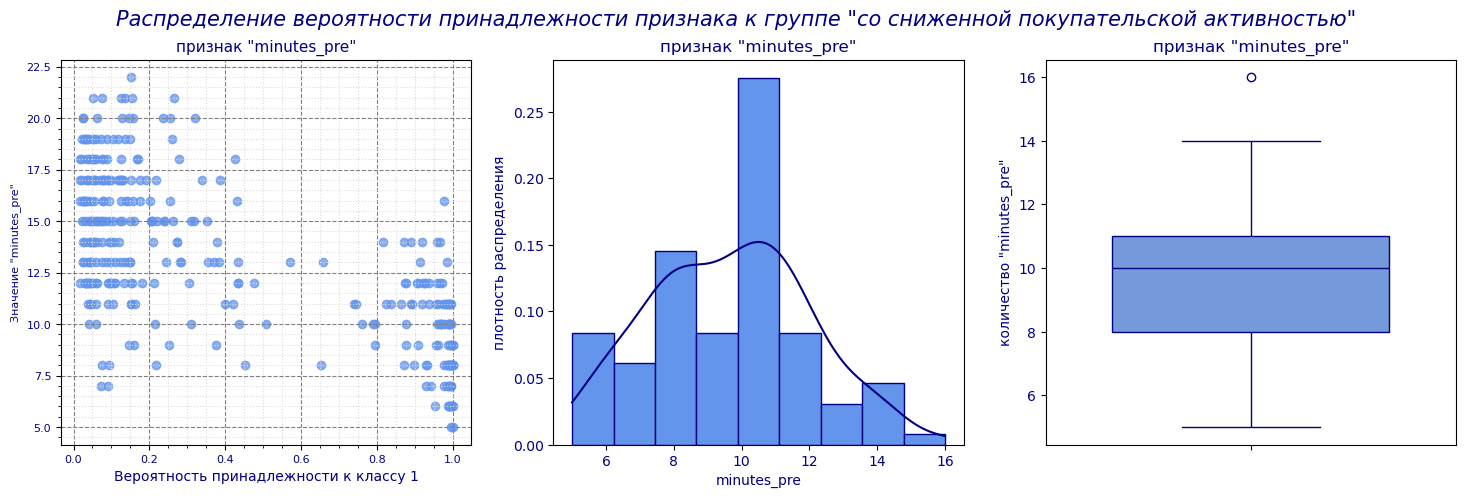

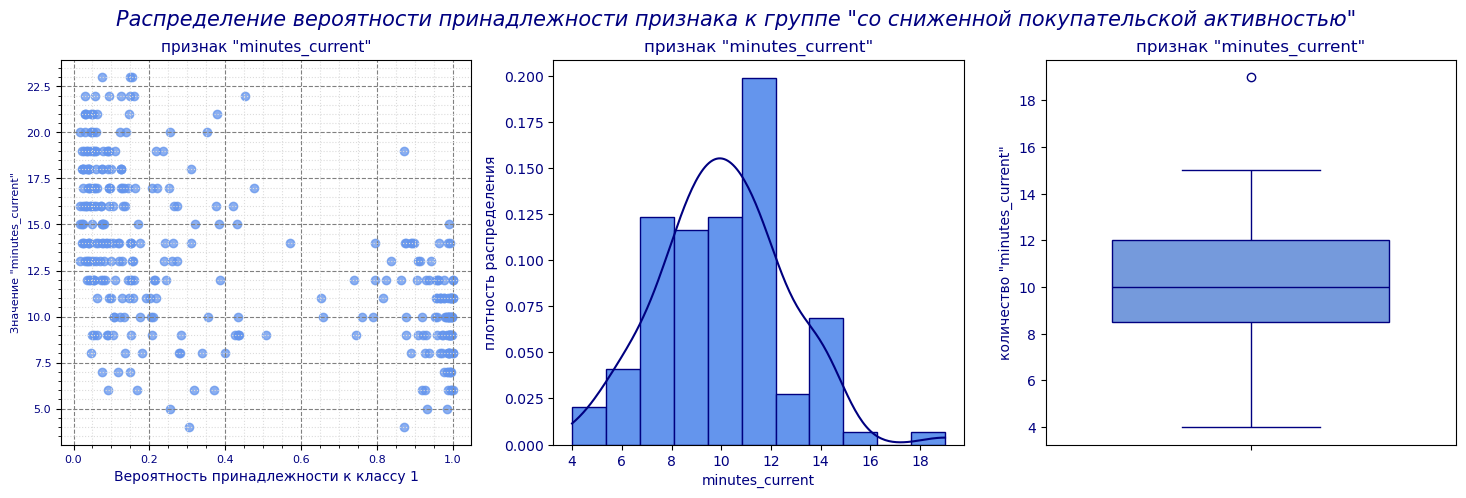

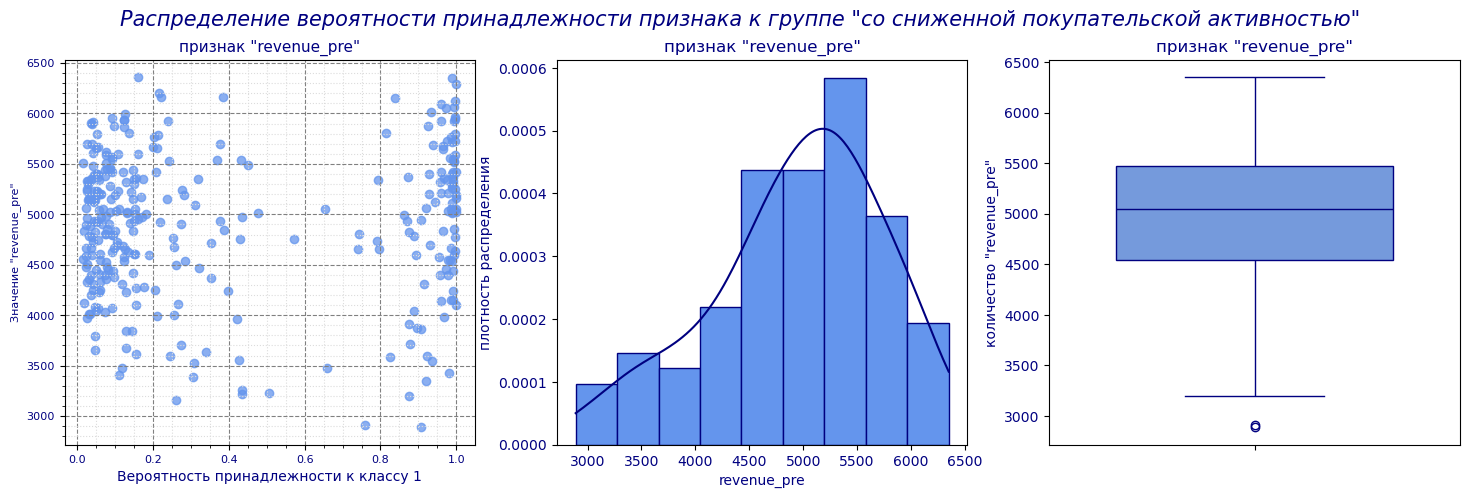

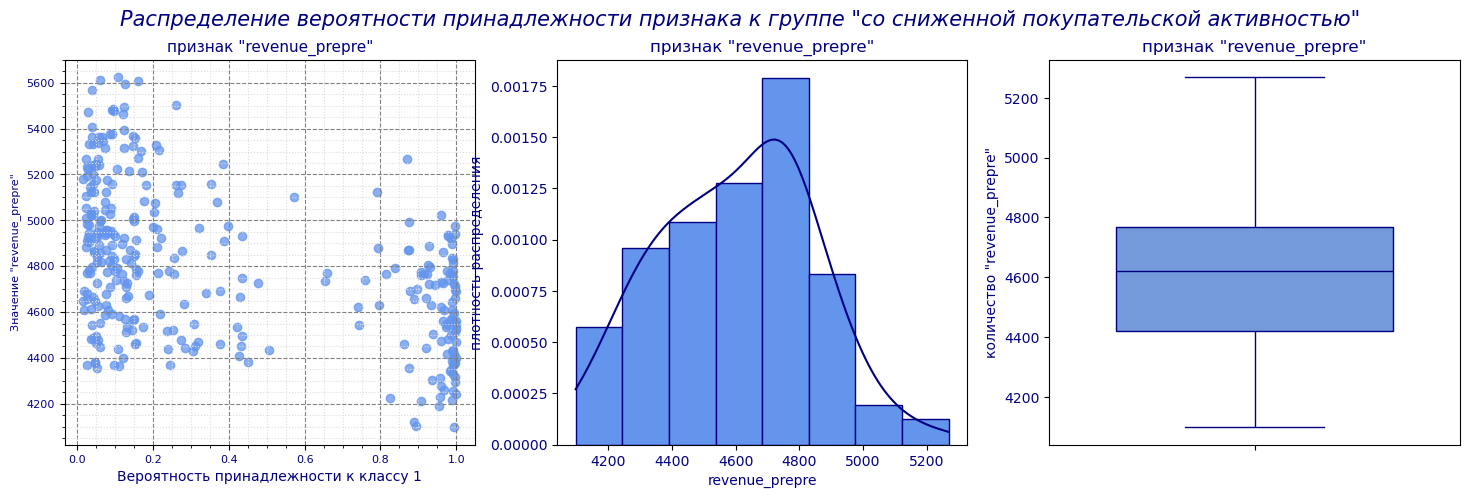

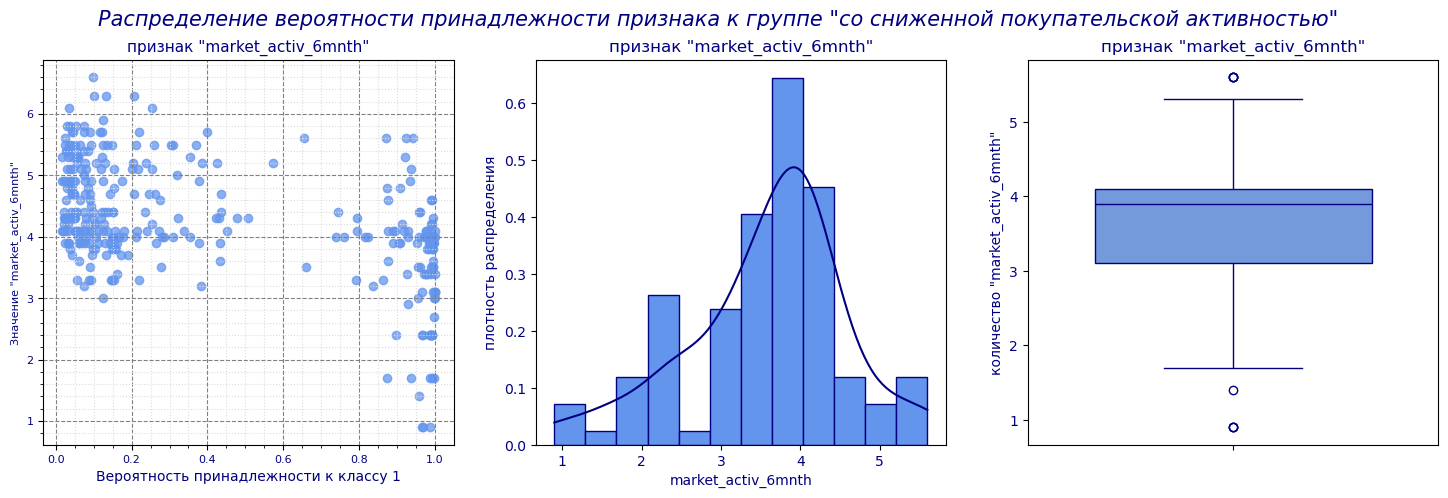

In [137]:
# Построим распределение вероятности принадлежности к группе со сиженным уровнем активности дл непрерывных кол. признаков
continuous_influ_num_cols = ['minutes_pre', 'minutes_current', \
                              'revenue_pre', 'revenue_prepre', 'market_activ_6mnth']
for col in continuous_influ_num_cols:
    num_feature_plot_2(X_test, X_test.query('probability > 0.5'), col, 'со сниженной покупательской активностью')

In [138]:
# соформируем функцию для визуализации распределения дискретных количественных признаков 
# в разрезе категорий целевого признака - покупательская активность
def num_feature_plot_3(df_1, df_2, col, class_):
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Распределение вероятности принадлежности признака к группе "{class_}"', \
                 color='navy', fontstyle='italic', fontsize=15)
    plt.subplot(1, 2, 1)
    x_values = X_test['probability']
    plt.scatter(x_values, df_1[col], color='cornflowerblue', alpha=0.75)
    # задаем параметры подписи осей и графика
    plt.title(f'признак "{col}"', color='navy', fontsize=11)
    plt.xlabel('Вероятность принадлежности к классу 1', color='navy', fontsize=10)
    plt.ylabel(f'Значение "{col}"' , color='navy', fontsize=8)
    plt.xticks(color='navy', fontsize=8)
    plt.yticks(color='navy', fontsize=8)
    plt.grid(color='grey', linestyle='--')
    plt.minorticks_on()
    plt.grid(which='minor', color='gainsboro', ls=':')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x = column, data=df_2, 
                  facecolor='cornflowerblue', edgecolor='navy', stat="percent")
    plt.xlabel(f'количество "{col}"', color = 'navy')
    plt.xticks(rotation=45, color='navy', fontsize=7)
    plt.ylabel('процент покупателей', color = 'navy')
    plt.title(f'признак "{col}"',  fontsize=12, color='navy')

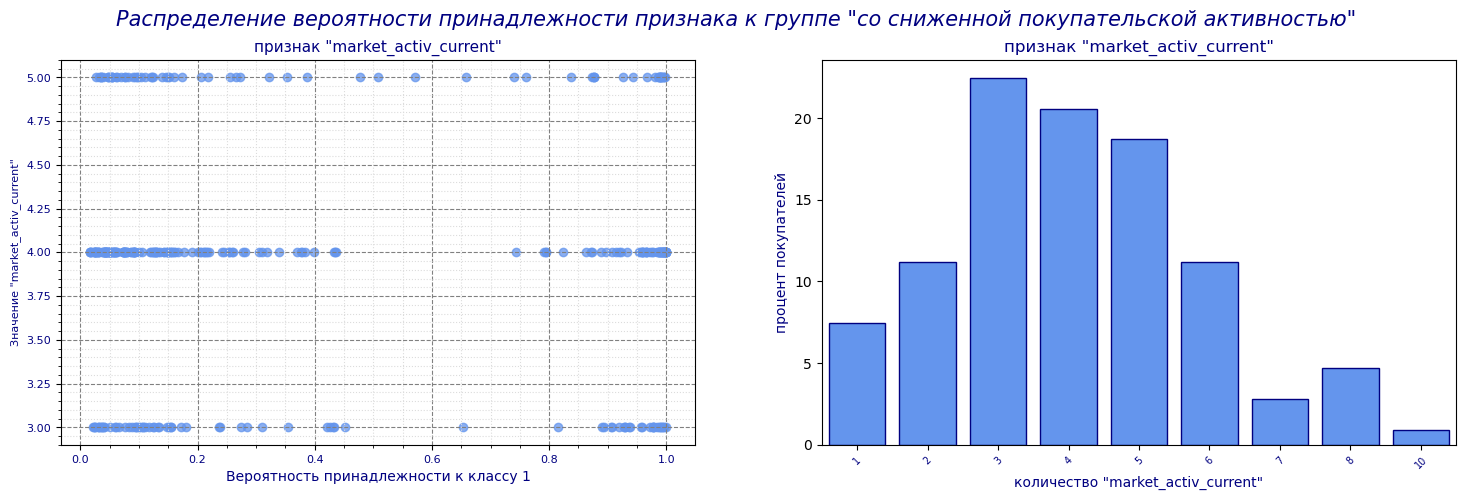

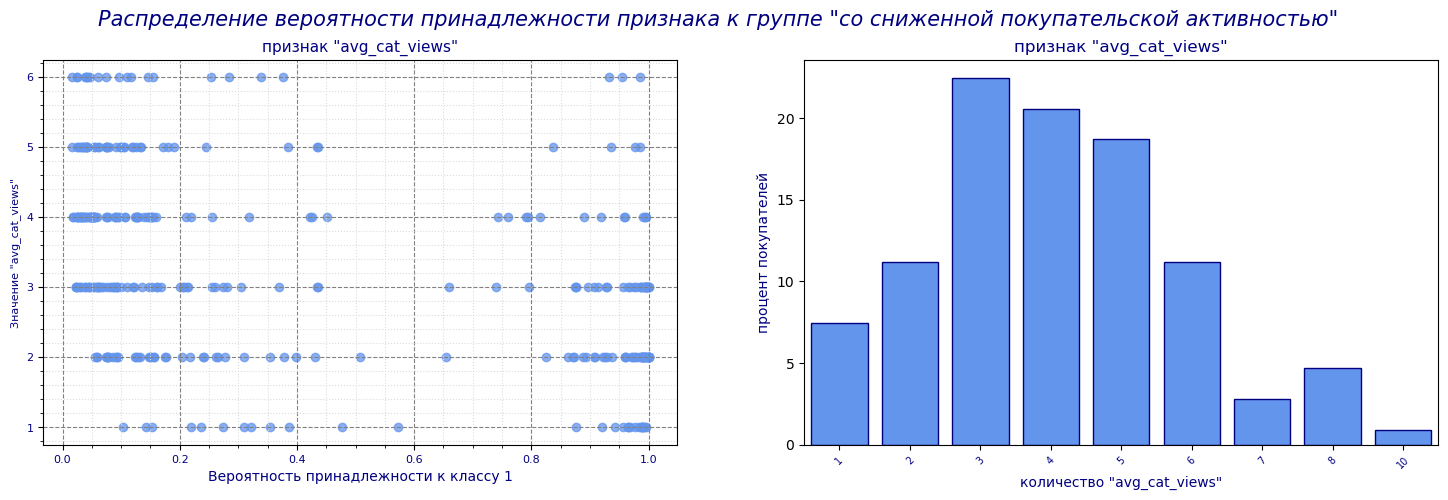

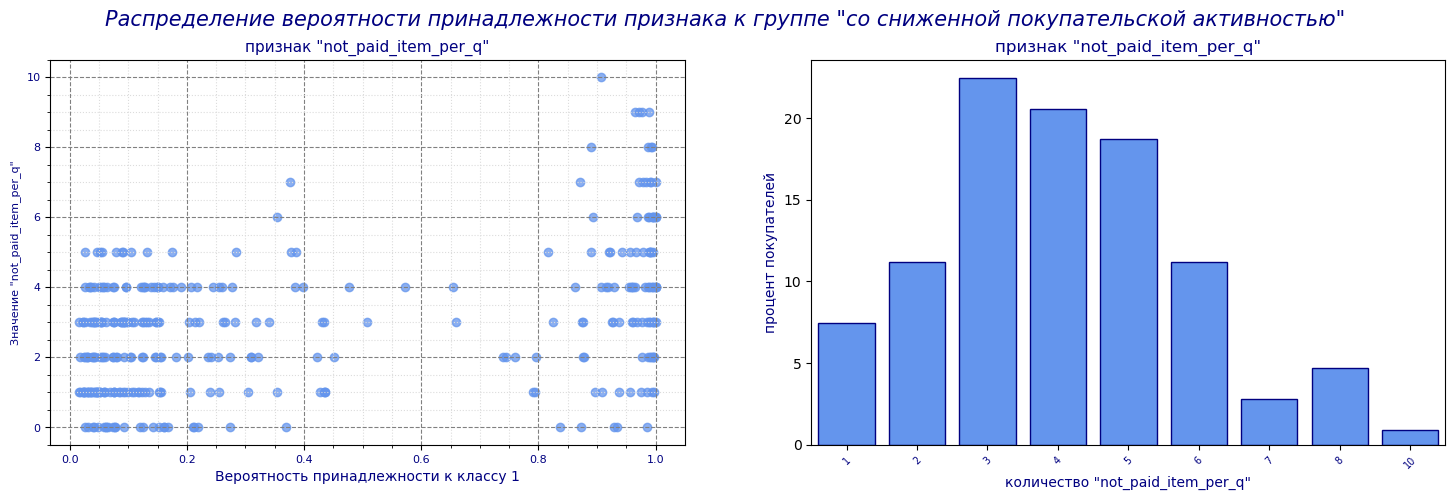

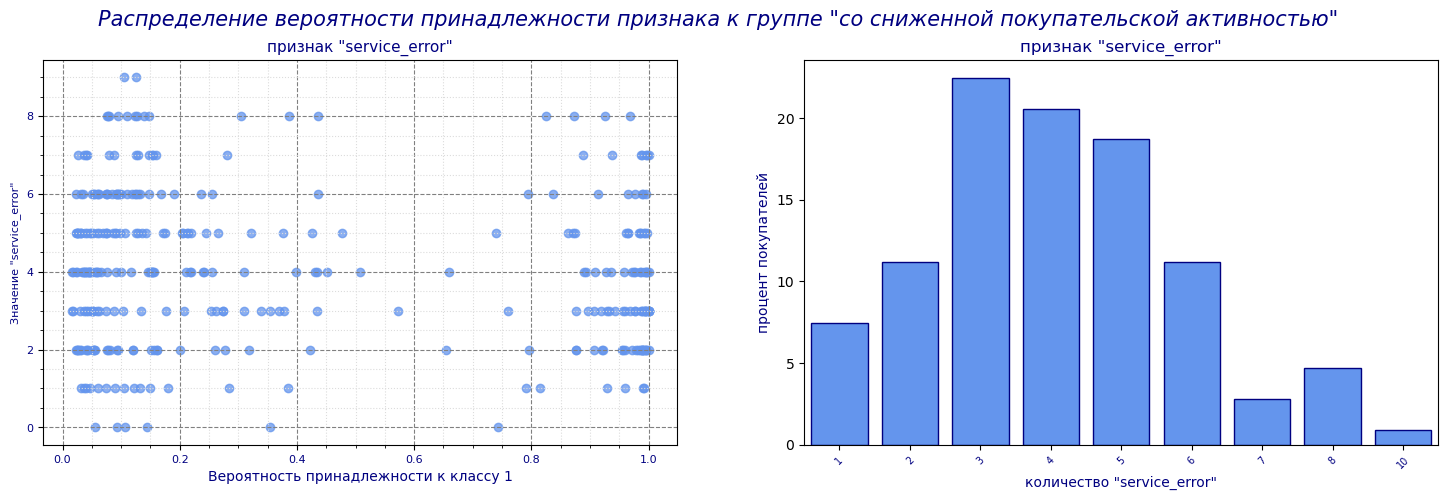

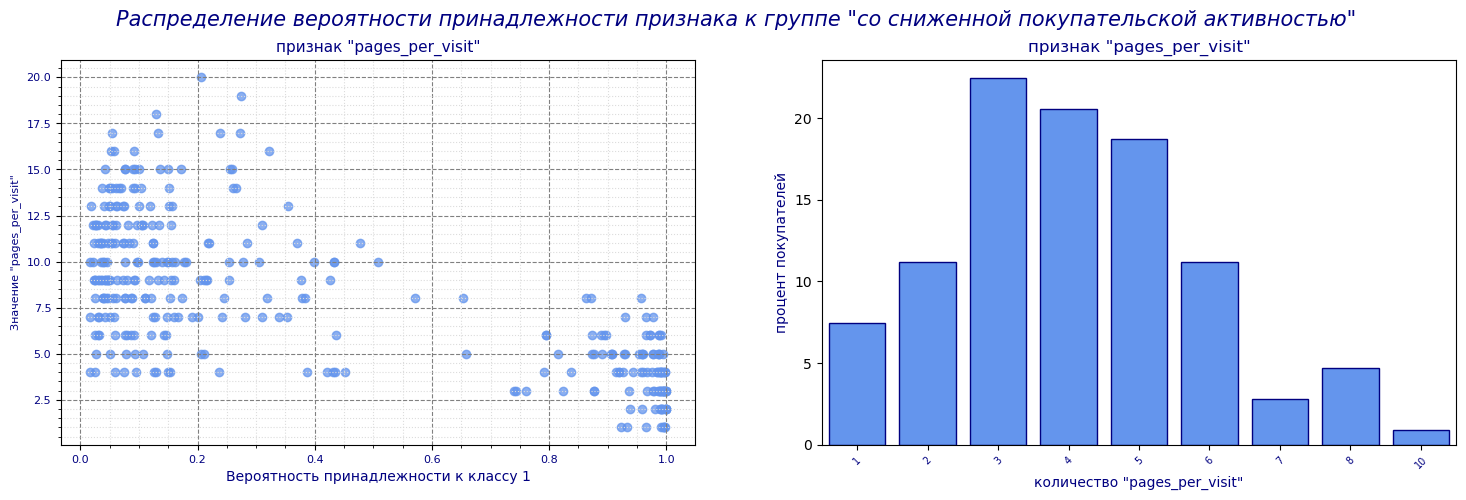

In [139]:
# Построим распределение вероятности принадлежности к группе со сиженным уровнем активности дл дискретных кол. признаков
discret_influ_num_cols = ['market_activ_current', 'avg_cat_views', 'not_paid_item_per_q', \
                          'service_error', 'pages_per_visit']
for col in discret_influ_num_cols:
    num_feature_plot_3(X_test, X_test.query('probability > 0.5'), col, 'со сниженной покупательской активностью')

In [140]:
def cat_feature_plot_2(df, col, ncols, naxes, class_):
    plt.subplot(1, ncols, naxes)
    plt.title(f'Распределение "{col}" \nпокупателей группы \n"{class_}"', color='navy', fontsize=11)
    plt.pie(x=df[col].value_counts(),
            startangle=90,
            labeldistance=1.1, 
            wedgeprops={'linewidth': 2, 'edgecolor':'whitesmoke'}, shadow=True, \
            textprops={'fontsize': 10, 'color': 'darkblue'},
            autopct='%1.1f%%',
            labels=list(df[col].unique()), 
            colors=sns.color_palette('Blues_r'))

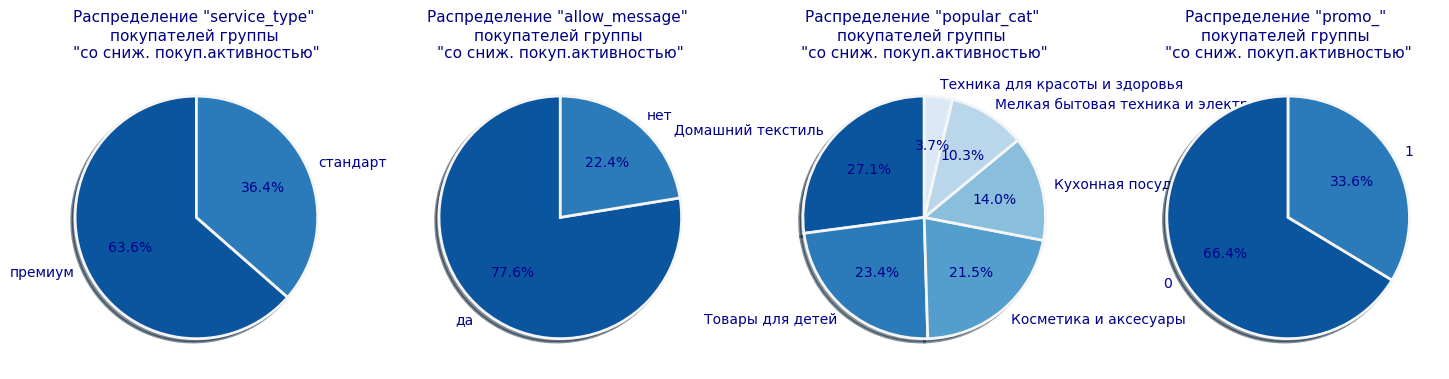

In [141]:
buying_1 = X_test.query('probability > 0.5')
influ_cat_cols = ['service_type', 'allow_message', 'popular_cat', 'promo_']
i = 1
plt.figure(figsize=(18,8))
for col in influ_cat_cols:
    cat_feature_plot_2(buying_1, col, len(influ_cat_cols), i, 'со сниж. покуп.активностью')
    i += 1

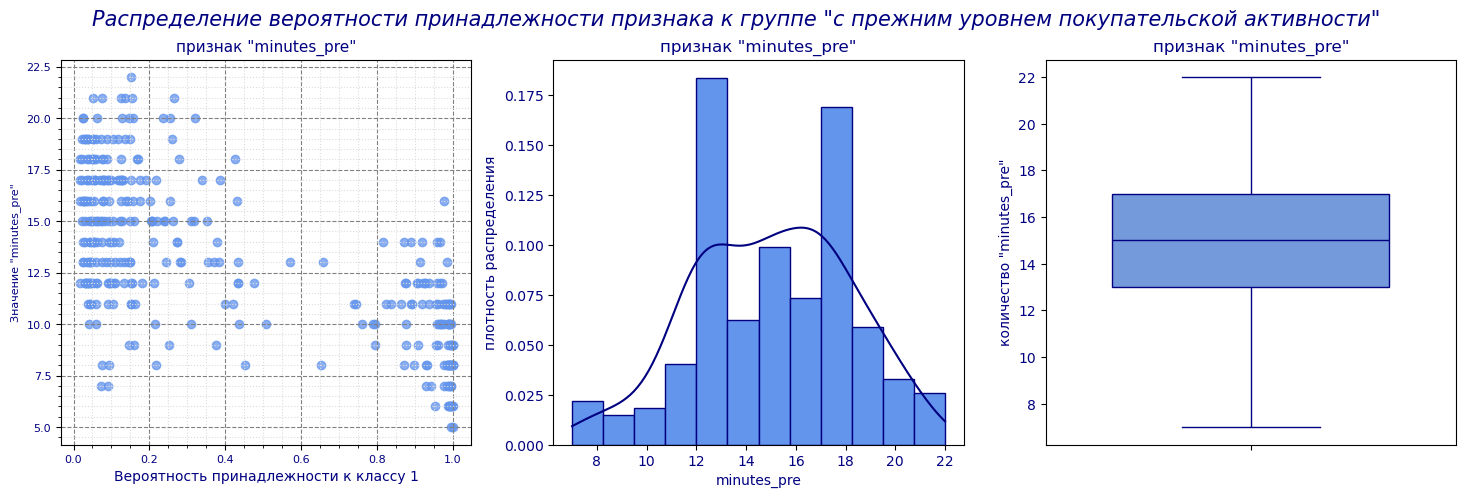

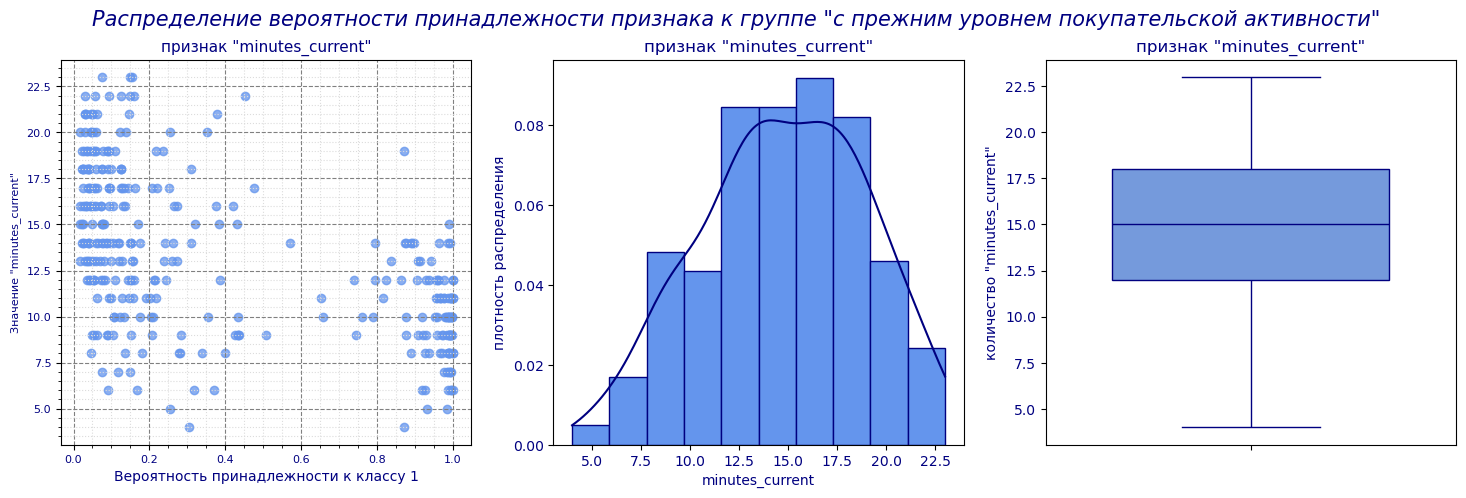

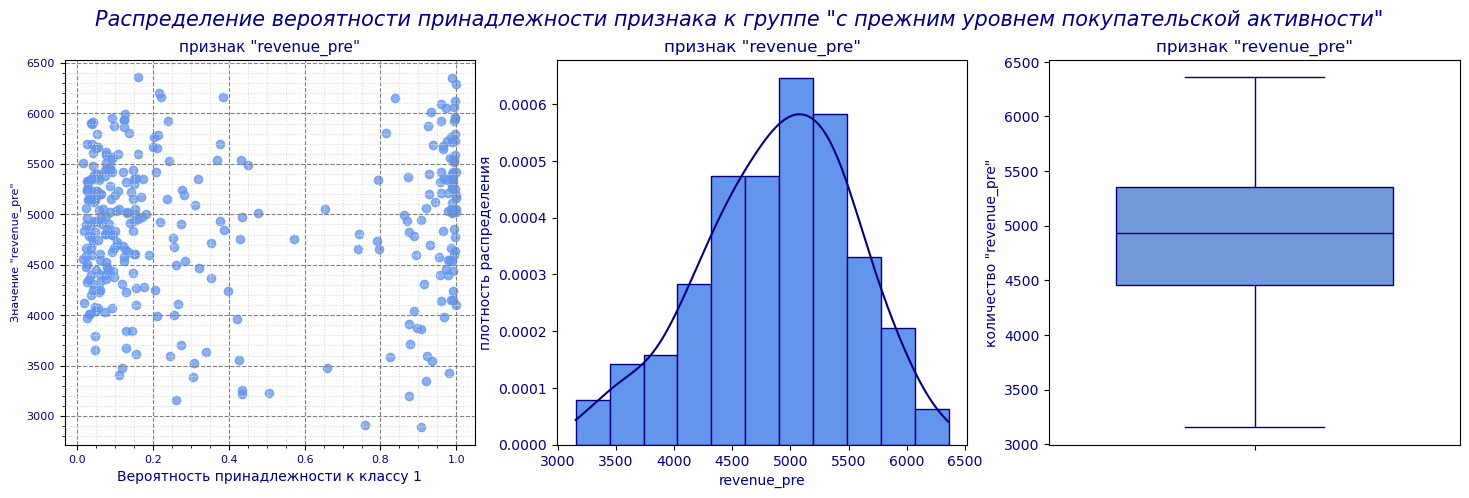

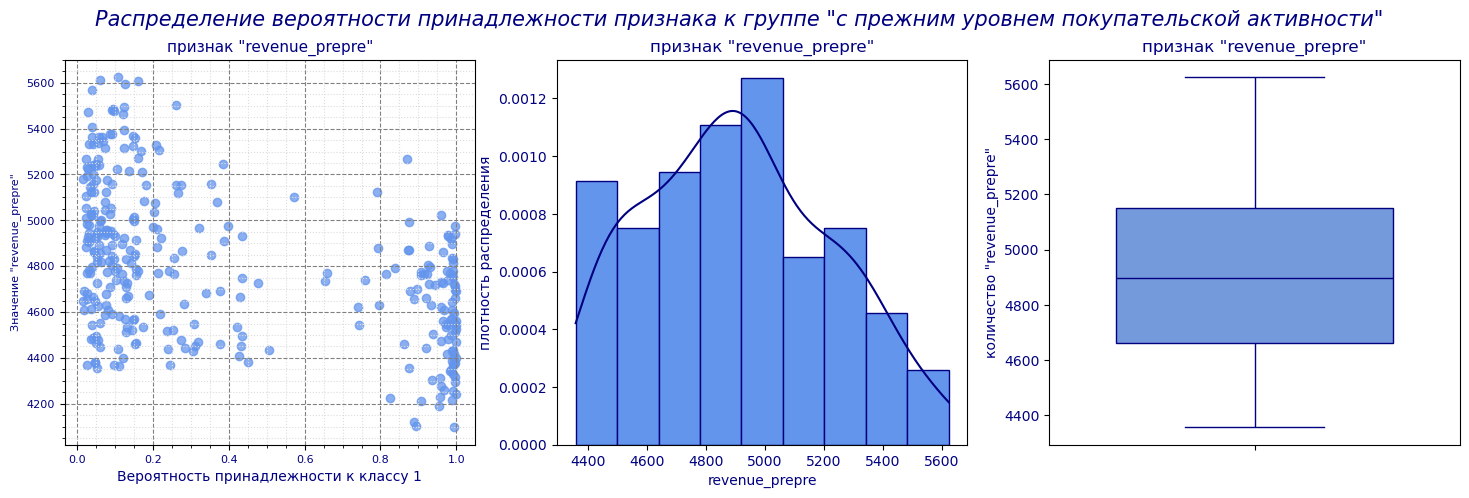

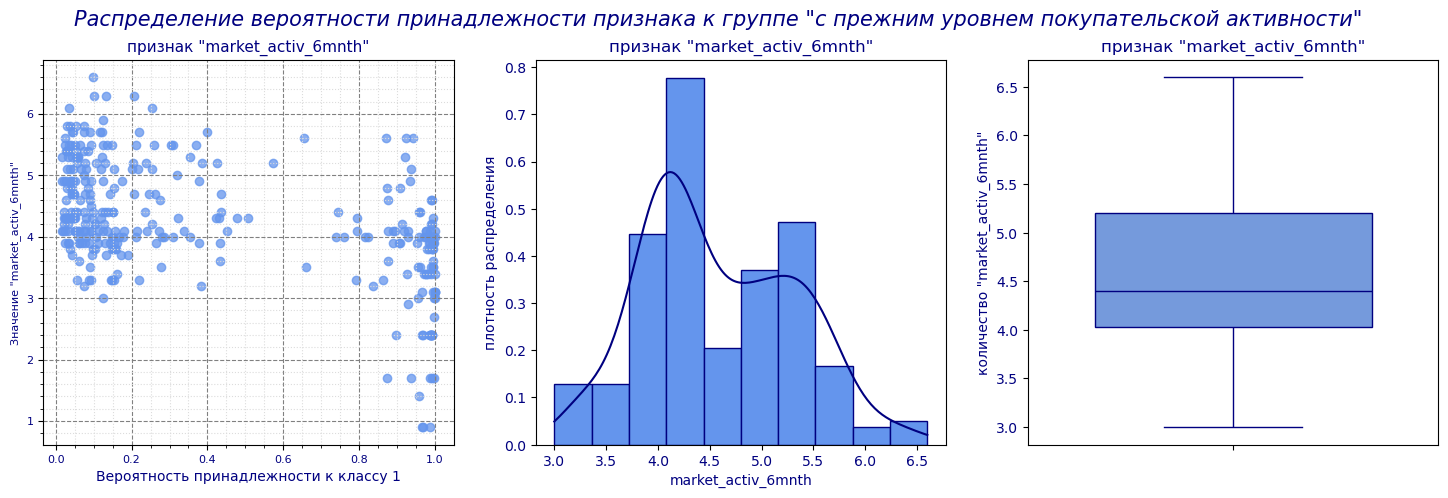

In [142]:
# Построим распределение вероятности принадлежности к группе с преждним уровнем активности дл непрерывных кол. признаков
for col in continuous_influ_num_cols:
    num_feature_plot_2(X_test, X_test.query('probability <= 0.5'), col, 'с прежним уровнем покупательской активности')

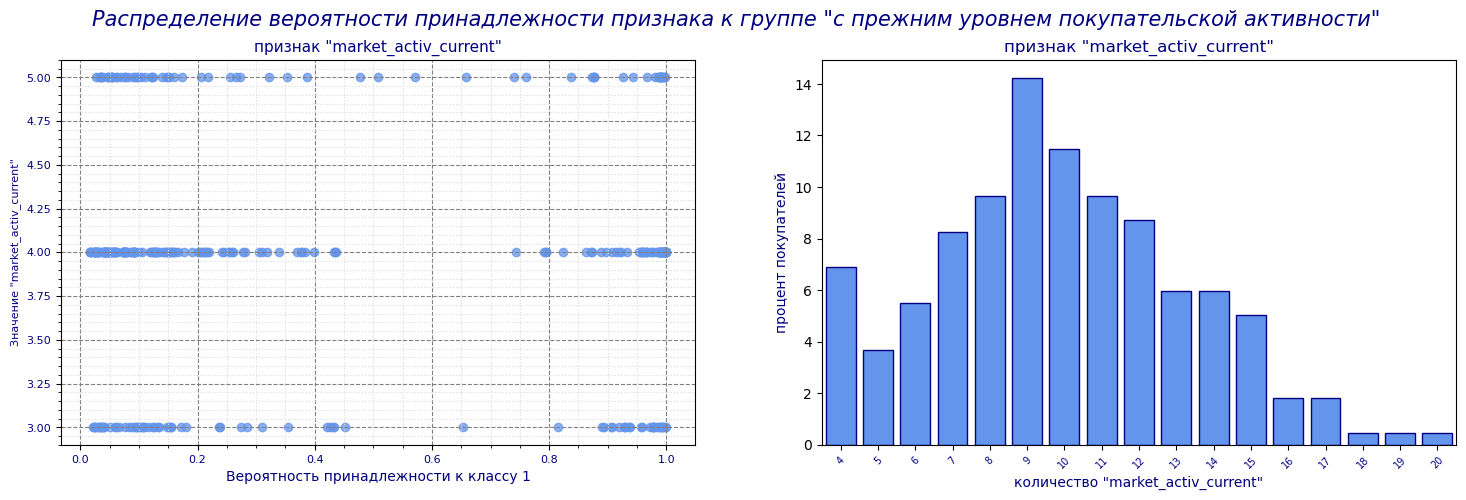

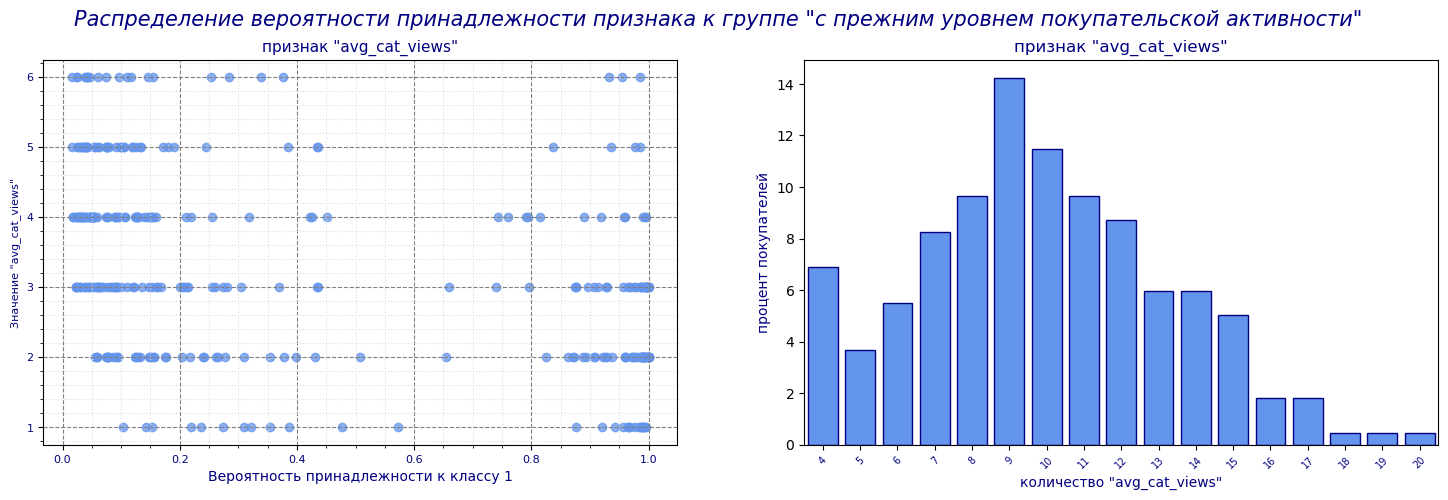

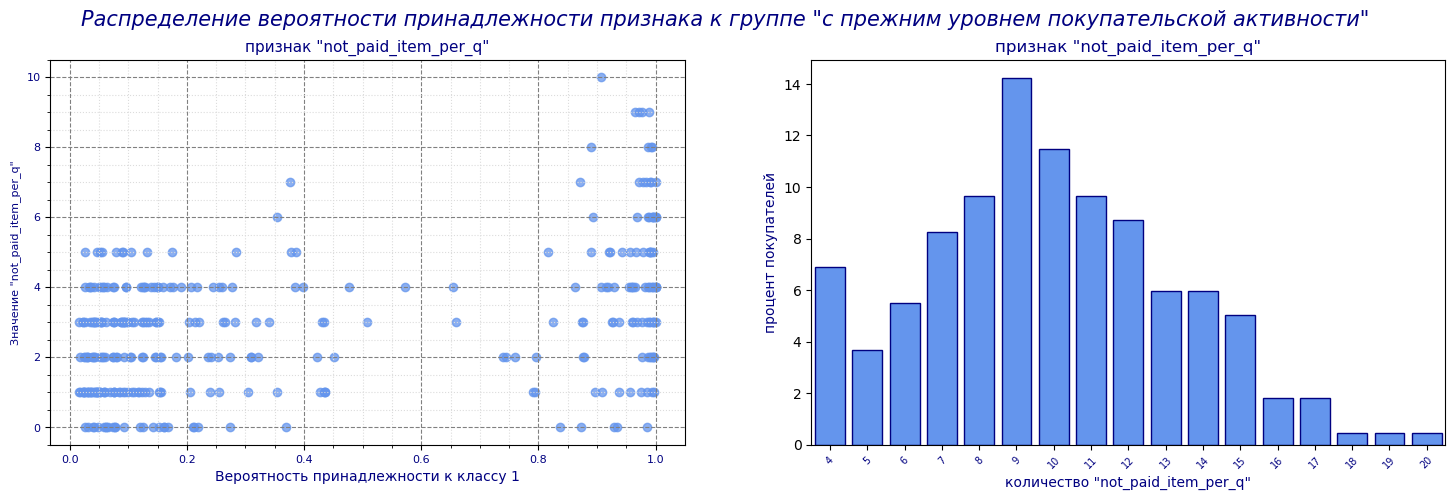

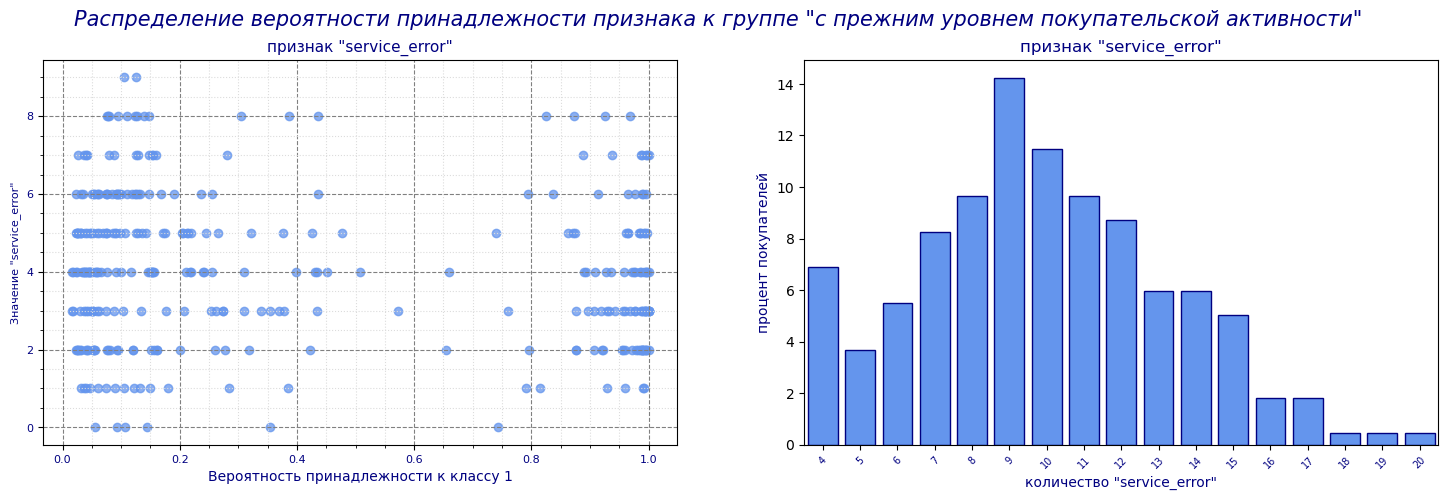

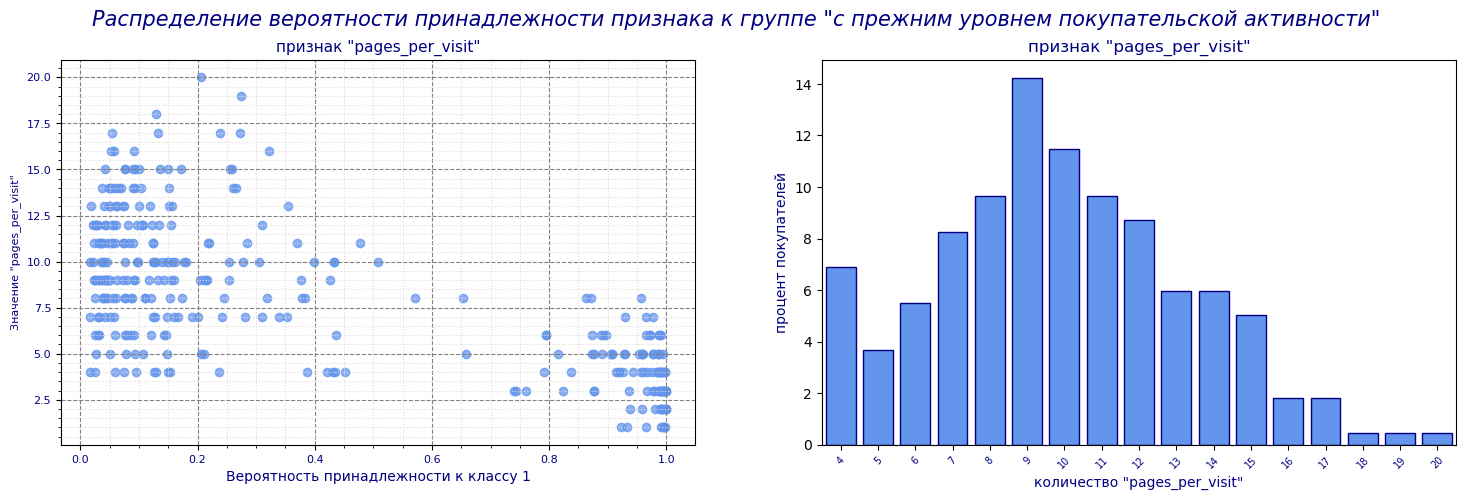

In [143]:
# Построим распределение вероятности принадлежности к группе с преждним уровнем активности дл дискретных кол. признаков
for col in discret_influ_num_cols:
    num_feature_plot_3(X_test, X_test.query('probability <= 0.5'), col, 'с прежним уровнем покупательской активности')

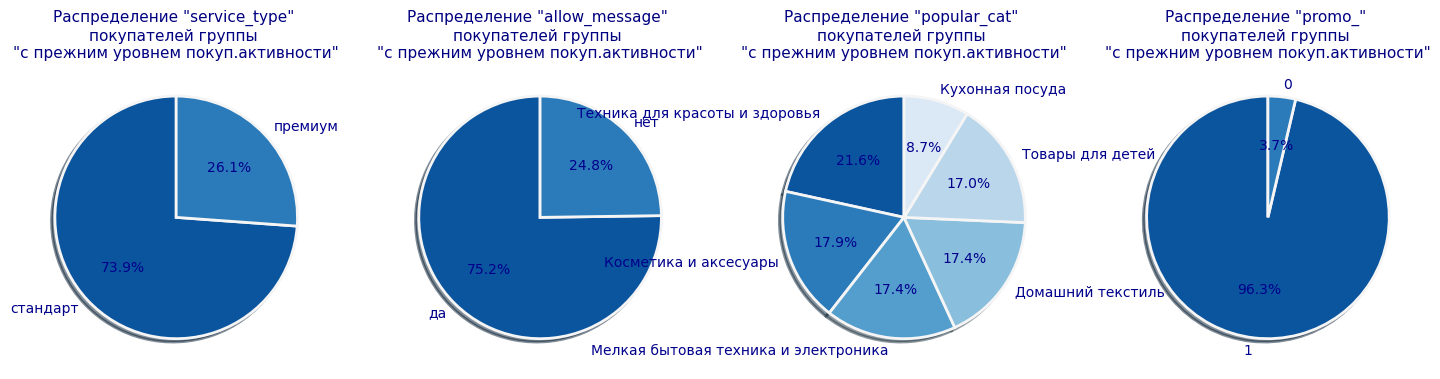

In [144]:
buying_0 = X_test.query('probability <= 0.5')
i = 1
plt.figure(figsize=(18,8))
for col in influ_cat_cols:
    cat_feature_plot_2(buying_0, col, len(influ_cat_cols), i, 'c прежним уровнем покуп.активности')
    i += 1

<font color='Darkblue'><i><b>Комментарий

<font color='Darkblue'><i>Из графиков распределения вероятности отнесения покупателя к <b>группе со сниженным уровнем покупательской активности</b> (класс_1), можно сделать следующие выводы о покупателях этого класса:<br><b>- `minutes_pre` и `minutes_current` </b>- время проведенное на сайте в основном не превышает 12 минут<br><b>- `avg_cat_views` </b>- количество просмотренных категорий в основном не превышает 3 категории<br><b>- `pages_per_visit` </b>- количество страниц редко превышает 6 страниц<br><b>- `revenue_pre` </b>- распределение выручки в предшествующем месяце не сильно отличается по классам, тогда как <b>`revenue_prepre` </b>- выручка предпредыдущего месяца в основном ниже 4,500 (вероятность принадлежности к классу 0 характеризуют показатели выручки в основном выше 4,500) <br><b>- `market_activ_6mnth` </b>- количество контактов у покупателей в основном менее 3-4 раз , <br><b>- `market_activ_curent` </b>- количество маркетинговых контактов в основном не превышает 4 раз,<br><b>- `not_paid_item_per_q` </b>- основная доля покупателей этой категории сохраняет в течение квартала от 2 до 5 неоплаченных товаров в корзине,<br>- превалирует доля покупателей с типом сервиса <b>премиум, разрешающие отправку сообщений, приобретающие в основном домашний текстиль, товары для детей, косметику и аксесуары, а также покупатели, не приобретающие товары по акциям.

<font color='Darkblue'><i>Из преставленных графиков распределения вероятности отнесения покупателя к <b>группе с прежним уровнем покупательской активности</b> (класс_0), можно сделать следующие выводы о покупателях этого класса:<br><b>- `minutes_pre` и `minutes_current` </b>- время проведенное на сайте в основном превышает 12.5 минут<br><b>- `avg_cat_views` </b>- количество просмотренных категорий в основном составляет от 3 до 5 категорий<br><b>- `pages_per_visit` </b>- количество страниц, как правило, превышает 8 страниц<br><b>- `revenue_pre` и `revenue_prepre` </b>- выручка предыдущего и предпредыдущего месяцев в основном превышает 4,500 <br><b>- `market_activ_6mnth` </b>- среднее количество контактов за прошедшие 6 мес. у покупателей, как правило, превышает 4 контакта <br><b>- `market_activ_curent` </b>- текущее количество маркетинговых контактов в основном составляет 4 контакта<br><b>- `not_paid_item_per_q` </b>- основная доля покупателей этой категории сохраняет в течение квартала не более 3 неоплаченных товаров в корзине,<br>- превалирует доля покупателей <b>приобретающих товары по акциям, с типом сервиса стандарт, разрешающие отправку сообщений, приобретающие в основном технику для красоты и здоровья.

### Прибыль от покупателя по группам

<font color='Darkblue'><i> Посмотрим на прибыль от покупателей в разрезе покупательской активности

In [150]:
money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1297 non-null   int64  
 1   profit  1297 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


In [151]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1297 non-null   int64  
 1   buying_activ          1297 non-null   object 
 2   service_type          1297 non-null   object 
 3   allow_message         1297 non-null   object 
 4   market_activ_6mnth    1297 non-null   float64
 5   market_activ_current  1297 non-null   int64  
 6   duration              1297 non-null   int64  
 7   promo_buy             1297 non-null   float64
 8   popular_cat           1297 non-null   object 
 9   avg_cat_views         1297 non-null   int64  
 10  not_paid_item_per_q   1297 non-null   int64  
 11  service_error         1297 non-null   int64  
 12  pages_per_visit       1297 non-null   int64  
 13  revenue_current       1296 non-null   float64
 14  revenue_pre           1297 non-null   float64
 15  revenue_prepre       

In [152]:
market_file = market_file.merge(money, on='id', how='left')
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1297 non-null   int64  
 1   buying_activ          1297 non-null   object 
 2   service_type          1297 non-null   object 
 3   allow_message         1297 non-null   object 
 4   market_activ_6mnth    1297 non-null   float64
 5   market_activ_current  1297 non-null   int64  
 6   duration              1297 non-null   int64  
 7   promo_buy             1297 non-null   float64
 8   popular_cat           1297 non-null   object 
 9   avg_cat_views         1297 non-null   int64  
 10  not_paid_item_per_q   1297 non-null   int64  
 11  service_error         1297 non-null   int64  
 12  pages_per_visit       1297 non-null   int64  
 13  revenue_current       1296 non-null   float64
 14  revenue_pre           1297 non-null   float64
 15  revenue_prepre       

In [153]:
market_file.pivot_table(index = 'buying_activ', values={'profit', 'revenue_prepre'}, \
                        aggfunc={'profit':{'sum', 'count'}, 'revenue_prepre':'mean'}).reset_index()

buying_activ profit          revenue_prepre
                    count      sum           mean
0  Прежний уровень    802 3,204.45       4,933.48
1        Снизилась    495 1,980.45       4,679.03

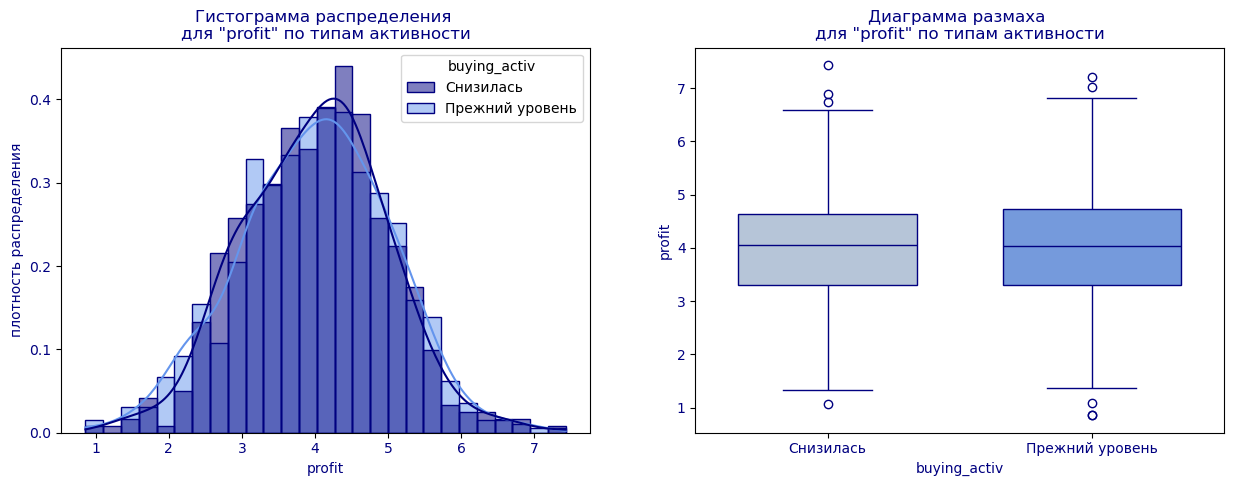

In [154]:
continuous_num_feature_plot_2(market_file, 'profit')

<font color='Darkblue'><i> Прибыль от покупателей со сниженным уровнем покупательской активности и прежним находится почти в одинаковом диапазоне, и распределена нормально в обеих группах.

### Профиль покупателя, со снижающейся покупательской активностью

<font color='Darkblue'><i> Поскольку прибыль по обеим покупательским подгруппам находится в одинаковомм диапазоне, сегментируем покупателей по ключевым признакам, влияющим на снижение покупательской активности: количество минут в предшествующем месяце, среднее количество категорий, в среднем просмотренных за визит в течение последнего месяца, и количество страниц, в среднем просмотренных за визит в течение последних 6 месяцв

In [158]:
buyers_reduced_level = market_file.query('minutes_pre <= 12 \
                    and avg_cat_views <= 3 \
                    and pages_per_visit <= 6')
buyers_reduced_level.drop(['id', 'minutes_pre', 'avg_cat_views', 'pages_per_visit'], axis=1) \
                    .describe(percentiles=[.125, .5, .875])

market_activ_6mnth  market_activ_current  duration  promo_buy  \
count              275.00                275.00    275.00     275.00   
mean                 3.58                  4.11    622.24       0.48   
std                  1.09                  0.71    220.35       0.30   
min                  0.90                  3.00    163.00       0.12   
12.5%                2.40                  3.00    344.25       0.22   
50%                  3.80                  4.00    638.00       0.33   
87.5%                4.60                  5.00    874.50       0.94   
max                  5.80                  5.00  1,065.00       0.99   

       not_paid_item_per_q  service_error  revenue_current  revenue_pre  \
count               275.00         275.00           275.00       275.00   
mean                  3.98           3.82         5,345.60     5,020.19   
std                   2.27           1.94           927.49       803.31   
min                   0.00           1.00         2,758.70     2,890.00   
12.5%                 1.00           2.00         4,175.93     3,945.00   
50%                   4.00           3.00         5,424.20     5,134.50   
87.5%                 7.00           6.75         6,314.52     5,893.25   
max                  10.00           8.00         7,799.40     6,716.50   

       revenue_prepre  minutes_current  profit  
count          275.00           275.00  275.00  
mean         4,609.57            10.33    4.02  
std            258.54             2.89    1.00  
min          4,098.00             4.00    1.06  
12.5%        4,305.75             7.00    2.84  
50%          4,600.00            10.00    4.11  
87.5%        4,928.50            14.00    5.06  
max          5,464.00            23.00    7.43

In [159]:
def num_feature_plot_3(df, col, ncols, naxes):
    plt.subplot(2, int(ncols/2), naxes)
    plt.suptitle(f'Распределение признаков для покупателей c метриками сниженной покупательской активности', 
                 fontsize=15, color='navy')
    df[col].hist(bins=25, density=True, color='cornflowerblue', edgecolor='navy')
    sns.kdeplot(df[col], color = 'navy',  label='kde')
    plt.title(f'"{col}"', color='navy')
    plt.xlabel(f'"{col}"', color='navy')
    plt.ylabel('плотность распределения', color='navy')
    plt.legend()

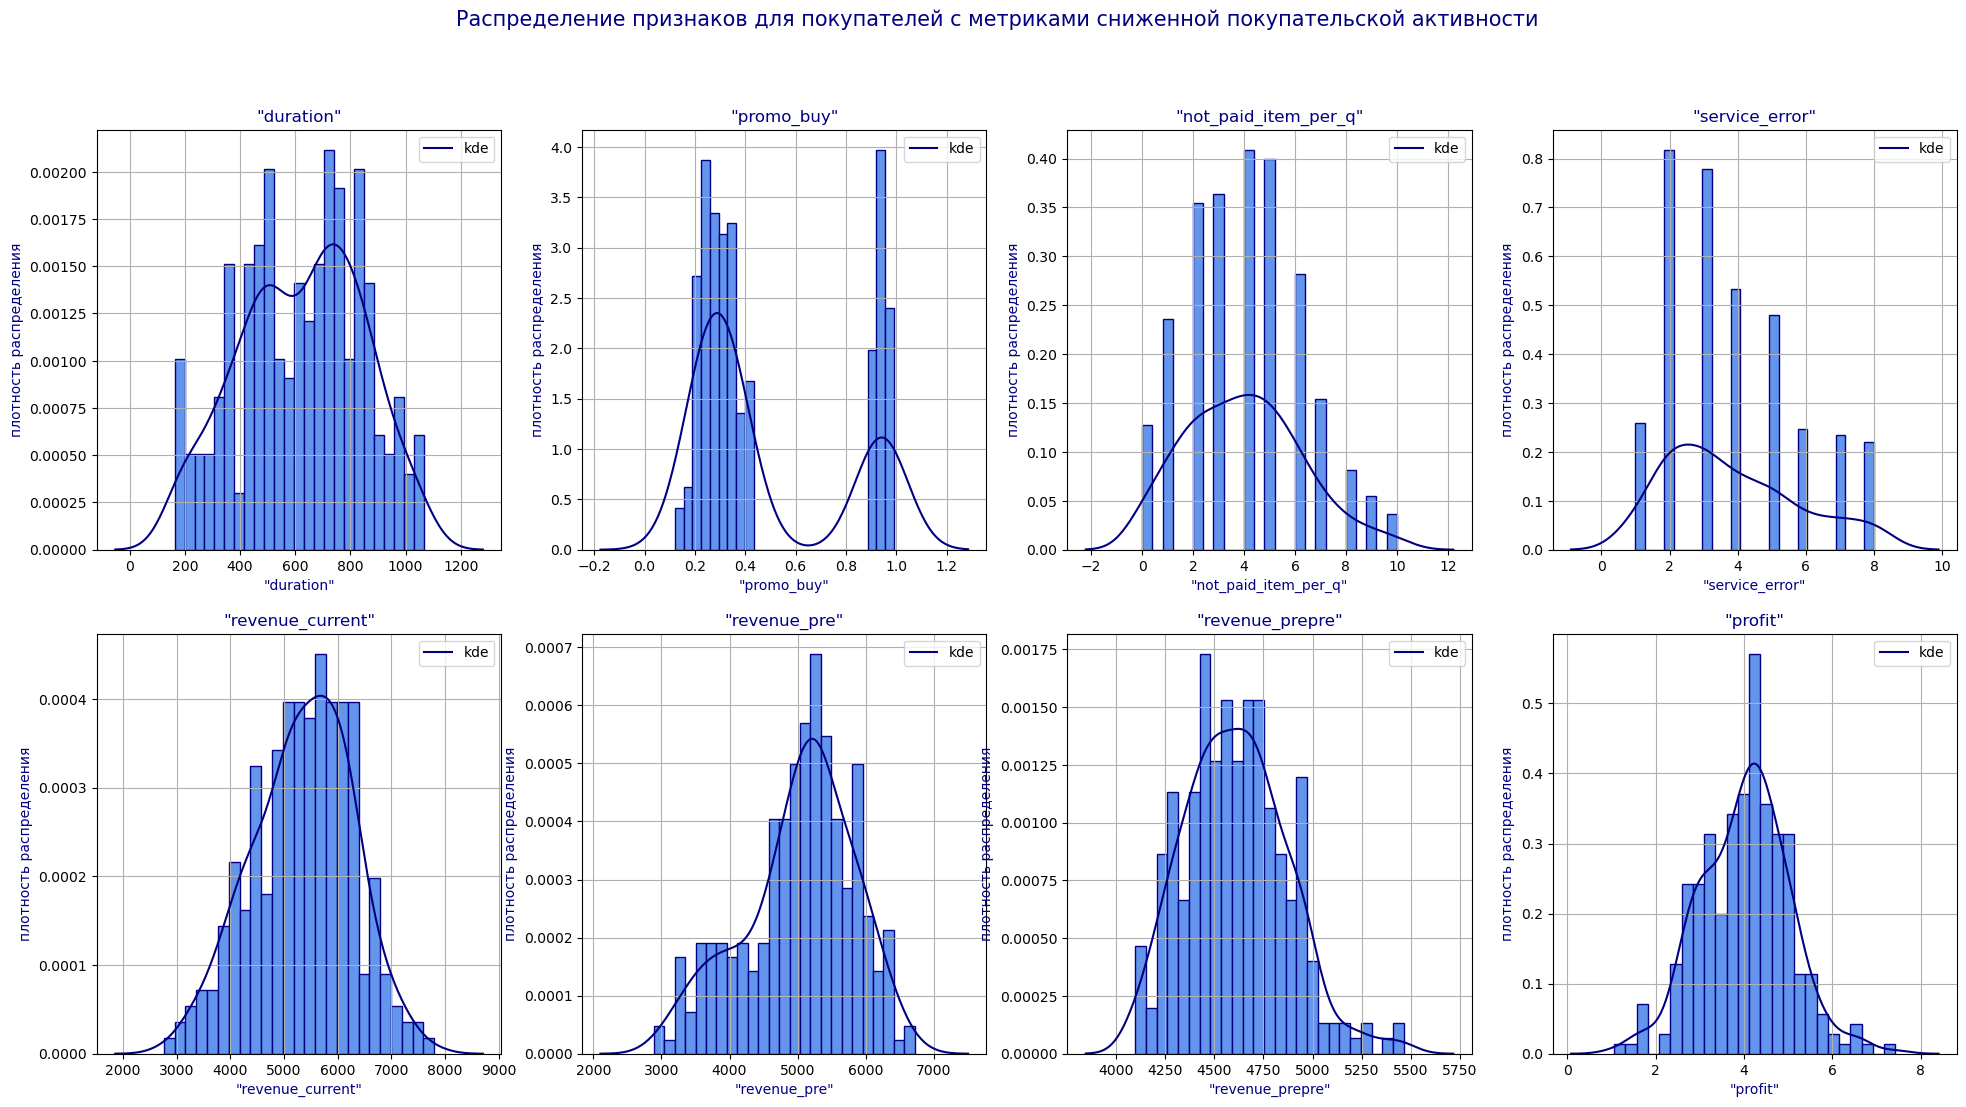

In [160]:
reduced_buyers_num_cols = [
                             'duration',
                             'promo_buy',
                             'not_paid_item_per_q',
                             'service_error',
                             'revenue_current',
                             'revenue_pre',
                             'revenue_prepre',
                             'profit']

plt.figure(figsize=(24, 12))
for i in range(1, len(reduced_buyers_num_cols)+1):
    num_feature_plot_3(buyers_reduced_level, reduced_buyers_num_cols[i-1], len(reduced_buyers_num_cols), i)


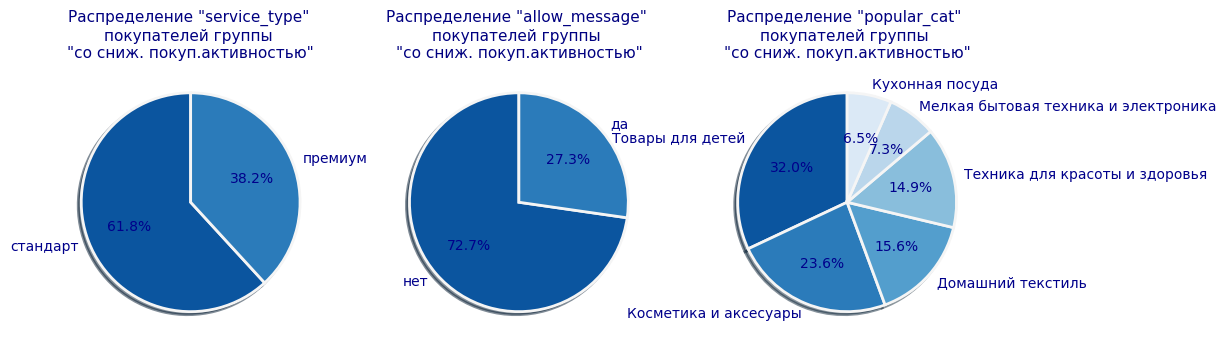

In [161]:
reduced_buyers_cat_col = buyers_reduced_level.drop(['id', 'buying_activ'], axis=1).select_dtypes(include='object').columns.to_list()
i = 1
plt.figure(figsize=(12, 6))
for col in reduced_buyers_cat_col:
    cat_feature_plot_2(buyers_reduced_level, col, len(reduced_buyers_cat_col), i, 'со сниж. покуп.активностью')
    i += 1

### Резюме

<font color='Darkblue'><i><b>Покупатели группы со сниженным уровнем покупательской активности</b><br>- проводят на сайте в основном не более 12 минут<br>- просмотрели за последний месяц не более 3х категорий товаров<br>- количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, редко превышает 6 страниц<br>- выручка, которую покупатель принес магазину в предпредыдущем месяце в основном ниже 4,500 <br>- количество маркетинговых контактов с покупателем в основном менее 3-4 раз<br>- основная доля покупателей этой категории сохраняет в корзине в течение квартала от 2 до 5 неоплаченных товаров<br>- предпочитают премиальный тип сервиса, разрешают отправку сообщений, приобретат в основном домашний текстиль, товары для детей, косметику и аксесуары, и, как правило, не покупают товары по акциям.

<font color='Darkblue'><i><b>Покупатели группы с прежним уровнем покупательской активности</b><br>- проводят на сайте в основном свыше 12.5 минут<br>- просмотрели за последний месяц от 3х до 5 категорий товаров<br>- количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, как правило превышает 8 страниц<br>- выручка, которую покупатель принес магазину в предпредыдущем месяце в основном превышает 4,500 <br>- количество маркетинговых контактов с покупателем в основном составляет 4 раза<br>- основная доля покупателей этой категории сохраняет в течение квартала не более 3 неоплаченных товаров в корзине,<br>- превалирует доля покупателей приобретающих товары по акциям, с типом сервиса стандарт, разрешающие отправку сообщений, приобретающие в основном технику для красоты и здоровья.

<font color='Darkblue'><i>Прибыль от покупателей со сниженным уровнем покупательской активности и прежним находится почти в одинаковом диапазоне, и распределена нормально в обеих группах.

<font color='Darkblue'>Покупателя по ключевым признакам, влияющим на <b><i>снижение покупательской активности: количество минут в предшествующем месяце не превышает 12 минут, количество просмотренных категорий товаров в среднем просмотренных за визит в течение последнего месяца, не превышает 3, за визит в течение последних 6 месяцев просматривается не более 6 страниц</b></i> - можно охарактеризовать следующим образом:<br>- период регистрации составляет 459 - 788 дней (от 1,5 до 2 лет)<br>- в среднем в текущем месяце проводит на сайте 10 минут<br>- не интересуется акциями<br>- в корзине в течение квартала созраняется в среднем 4 неоплаченных товара<br>- выручка от такого покупателя составляет 4-6 тыс<br>- не акцептует отправкку сообщений<br>- приобретает в основном товары для детей или косметику и аксессуары<br>- пользуется стандартным типом сервиса 

<font color='Darkblue'><b><i>Для повышения покупательской активности стоит увеличить количество маркетинговых контактов, обращая внимание покупателей на акции, проводимые магазином, и привелегии, получаемые покупатеями от использования премиального сервиса, а также пердлагаемую магазином технику для красоты и здоровья. Также стоит рассмотреть возможность оптимизации структуры сайта, для увеличения количества просматриваемых страниц и категорий товаров, и, как следствие, увеличение времени, проводимом покупателем на сайте

## Общий вывод

<Font color='navy'><b><i><u>Целю исследования являлась</b></i></u> - разработка рекомендаций для интернет-магазина "В один клик", которые позволят персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность

<font color='Darkblue'><b><i><u>I. Обзор предоставленных для исследования данных</b></i></u><br>

<font color='Darkblue'>A. Для исследования предоставлено 4 датасета<br>&nbsp;&nbsp;&nbsp;<b>1) `market_file`</b> содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении<br>&nbsp;&nbsp;&nbsp;<i>1300 записи, 13 колонок, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Покупательская активность` — рассчитанный класс покупательской активности<br>`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт»<br>`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре<br>`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев<br>`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце<br>`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте<br>`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев <br>`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев<br>`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца<br>`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца<br>`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта<br>`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца<br>&nbsp;&nbsp;&nbsp;<b>2) `market_money`</b>содеражит данные о выручке, которую получает магазин с покупателя<br>&nbsp;&nbsp;&nbsp;<i>3900 записи, 3 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Период` - название периода, во время которого зафиксирова выручка<br>`Выручка` - сумма выручки, полученная магазином за период<br>&nbsp;&nbsp;&nbsp;<b>3) `market_time`</b>содеражит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода<br>&nbsp;&nbsp;&nbsp;<i>2600 записи, 3 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Период` — название периода, во время которого зафиксировано общее время<br>`минут` — значение времени, проведённого на сайте, в минутах<br>&nbsp;&nbsp;&nbsp;<b>4) `money`</b>содержит данные о среднемесячной прибыли покупателя за последние 3 месяца<br>&nbsp;&nbsp;&nbsp;<i>1300 записи, 2 колонки, дубикатов записей нет, пропусков данных нет</i><br>`id` — номер покупателя в корпоративной базе данных,<br>`Прибыль` — значение прибыли<br>
<font color='Darkblue'>B.  В рамках предподготовки данных <br>&nbsp;&nbsp;&nbsp; - изменен тип данных в колонках `market_file`('Маркет_актив_6_мес', 'Акционные_покупки') и `market_money`('Выручка')<br>&nbsp;&nbsp;&nbsp; - стандартизированы названия колонок<br>&nbsp;&nbsp;&nbsp; - удалены опечатки в значениях текстовых колонок<br>

<font color='Darkblue'><b><i><u>II. Анализ предоставленных для исследования данных</b></i></u><br>

<font color='Darkblue'><b><i>✔ Количественные показатели </b></i>:<br>&nbsp;&nbsp;&nbsp;- `market_activ_6mnth`(среднемесячная маркетинговая активность за последние 6 мес.), как и `market_activ_current` (текущая маркетинговая активность): у 75% покупателей находится в диапазоне от 3 до 5 раз, медиана - 4 контакта.<br>&nbsp;&nbsp;&nbsp;- `duration` (длительность с момента регистрации на сайте): распределение значений показателя нормальное, у 75% покупателей срок регистрации находится в диапазоне от 284 до 912 дней, среднее и медианное количество несильно отличаются и составляют 601 и 606 дней соответственно<br>&nbsp;&nbsp;&nbsp;- `promo_buy`(среднемесячная доля покупок по акции от общего числа покупок за последние 6 мес): на гистограмме видны две четкие области концентрации значений - в диапазоне от 0.1 до 0.4, где сконцентрировано наибольшее количество значений, и в диапазоне от 0.8 до 0.9, средний показатель составляет 0.32.<br>&nbsp;&nbsp;&nbsp;- `avg_cat_views` (среднее количество просмотренных категорий товаров): распределение значений показателя нормальное, у 75% покупателей количество просмотренных категорий колблется от 2 до 5, среднее и медианное количество составляет 3 категории товара<br>&nbsp;&nbsp;&nbsp;- `not_paid_item_per_q` (количество неоплаченных товаров в корзине за квартал): ассиметричное распределение значений показателя - положительная ассиметрия (большинство значений показателя расположена справа от моды), у 75% покупателей количество неоплаченных товаров находится в диапазоне от 1 до 5, среднее и медианное количество - 3 товара<br>&nbsp;&nbsp;&nbsp;- `servis_error` (ошибки сервиса): распределение значений показателя нормальное, у 75% покупателей число сбоев находится в диапазоне от 2 до 7 раз, среднее и медианное значения равны и составляют 4 сбоя<br>&nbsp;&nbsp;&nbsp;- `pages_per_visit` (число страниц, просмотренных за визит за последние 3 месяца): ассиметричное распределение значений показателя - положительная ассиметрия, у 75% покупателей число страниц находится в диапазоне от 4 до 13 страниц, среднее и медианное значения равны и составляют 8 страниц<br>&nbsp;&nbsp;&nbsp;- `revenue`(выручка от покупателя за период): распределение значений показателя нормально, у 75% покупателей ежемесячные расходы находятся в диапазоне от 4,353.95 до 5,755.12, значения медианы и среднего близки и составляют 4,957.5 и 5,025.7 соответственно<br>&nbsp;&nbsp;&nbsp;- `minutes`(минуты, проведенные покупателем за месяц): распределение значений показателя нормальное, 75% покупателей проводят на сайте от 9 до 19 минут в месяц, значения медианы и среднего близки и составляют 13.00 и 13.34 соответственно<br>&nbsp;&nbsp;&nbsp;- `profit` (прибыль от покупателя) нормально распределен, 75% покупателей в среднем за месяц приносят прибыль в диапазоне от 2.83 до 5.13. Максимальная среднемесячная прибыль составляет 7.43, среднее и медианное значения среднемесячной прибыли практически равны - 4.00 и 4.04 соответственно.<br>

<font color='Darkblue'><b><i>✔ Категорийные показатели </b></i><br>&nbsp;&nbsp;&nbsp;- `покупательская активность` (целевой признак) - две категории: 'прежний уровень' и 'снизилась', преобладает категория 'прежний уровень' - 61.7%<br>&nbsp;&nbsp;&nbsp;- `тип сервиса`(уровень сервиса) - две категории: 'премиум' и 'стандарт', преобладает категория 'стандарт' - 71.1%) <br>&nbsp;&nbsp;&nbsp;- `разрешене на отправку сообщений` - две категории: 'да' и 'нет', преобладает категория 'да' - 74.0%<br>&nbsp;&nbsp;&nbsp;- `популярная категория` - шесть категорий, преобладает категория 'товары для детей'(25.4%), наименее популярная - категория 'кухонная посуда' (10.6%)<br>&nbsp;&nbsp;&nbsp;- `периоды` - три категории: 'препредыдущий месяц', 'предыдущий месяц' и 'текущий месяц', расходы покупателей по месяцам распределены практичечски равномерно.<br>&nbsp;&nbsp;&nbsp;- `периоды` - две категории: 'предыдущий месяц' и 'текущий месяц', количество минут, проведенных покупателями на сайте как в предыдущем, так и в текущем практически равно.

<font color='Darkblue'><i><b>✔ Количественные и категорийные показатели в разрезе покупательской активности</i></b><br>&nbsp;&nbsp;&nbsp;<b>a) у покупателей с прежним уровнем покупательской активности выше уровень:</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- маркетинговых коммуникаций за последние 6 мес, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- среднее количество просмотренных категорий товаров, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- количество просмотренных страниц за визит, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- выручка за текущий месяц (при этом за прошлый и предпредыдущий - одинакова для обеих групп), <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- время, проведенное на сайте как в текущем, так и в прошлом месяце, <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- количество сбоев сервиса также превалирует у этой группы (при этом медиана - 4 сбоя - на одном уровне у обеих групп)<br><b>&nbsp;&nbsp;&nbsp;b) у покупателей со сниженной покупательской активностью выше уровень</b><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- доли акционных покупок <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- количества неоплаченных товаров в корзине<br>&nbsp;&nbsp;&nbsp;<b>c) примерно в одинаковых диапазонах </b>находится длительность с момента регистрации на сайте у покупателей обеих групп распределена в примерно в одинаковых диапазонах, с небольшим преимуществом в длительности по группе, чья покупательская активность снизилась<br>&nbsp;&nbsp;&nbsp;<b>d) доля преобладающего целевого признака по категориям идентична: по уровню сервиса (в обеих покупательских группах преобладает стандартный уровень), по согласию на отправку сообщений (преобладает акцепт отправки) и по по наиболее популярной товарной категории (мелкая бытовая техника)

<font color='Darkblue'><b>✔ В результате корреляционного анализа </b>объединенных данных выявлен высокий уровень корреляции между данными о выручке в текущем и предыдущем месяце, а также данными о периоде с момента регистрации на сайте и количестве неоплаченных покупок в корзине. Для избежания влияния мультиколлинеарности, данные о выручке за текущий месяц и о периоде с момента регистрации были удалены

<font color='Darkblue'><b><i><u>III. Выбор оптимальной модели для прогноза покупательской активности и определение значимых признаков покупательского поведения, влияющих на изменение покупательской активности</b></i></u><br>

<font color='Darkblue'>✔ В результате перебора моделей, их гиперпараметров и методов подготовки данных было определено, что <b>наилучшей моделью для прогнозирования покупательской активности является <b>модель опорных векторов - `SVC()` с масштабированием методом `StandardScaler()`</b><br> При такой конфигурации методов и модели метрика ROC-AUC на тренировочных составляет 0.9137, на тестовых - 0.9134

<font color='Darkblue'><b>✔ Наиболее значимыми признаками модели</b> являются<br>- <b>`pages_per_visit`</b> - количество просмотренных страниц: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`minutes_pre` и `minutes_current`</b> - количество минут, проведенных покупателем на сайте: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`avg_cat_viewse`</b> - среднее количество просмотренных категорий: значение выше - вероятность принадлежности к классу 1 ниже<br>- <b>`not_paid_item_per_q`</b> - количество неоплаченных товаров в корзине: прямая зависимость - значение выше - вероятность принадлежности к классу 1 выше<br>- <b>`revenue_prepre`</b> - выручка от покупателя за пердыдущий месяц: значение выше - вероятность принадлежности к классу 1 ниже<<br>- <b>`market_activ_6mnth`</b> - среднее количество маркетинговых контактов за последние 6 мес: значение выше - вероятность принадлежности к классу 1 ниже<br><i>Прямая зависимость: рост значения признака приводит к росту вероятности принадлежности объекта к классу 1 наблюдается у признаков `not_paid_item` (неоплаченные товары в корзине) и `promo_1` (доля товаров, приобретенных по скидке, более 50%)</b></i>

<font color='Darkblue'><b><i><u>IV. Покупательские сегменты</b></i></u><br>

<font color='Darkblue'><i><b>✔ Покупатели группы со сниженным уровнем покупательской активности</b><br>- проводят на сайте в основном не более 12 минут<br>- просмотрели за последний месяц не более 3х категорий товаров<br>- количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, редко превышает 6 страниц<br>- выручка, которую покупатель принес магазину в предпредыдущем месяце в основном ниже 4,800 <br>- количество маркетинговых контактов с покупателем в основном менее 3-4 раз<br>- основная доля покупателей этой категории сохраняет в корзине в течение квартала от 2 до 5 неоплаченных товаров<br>- предпочитают премиальный тип сервиса, разрешают отправку сообщений, приобретат в основном домашний текстиль, товары для детей, косметику и аксесуары, и, как правило, не покупают товары по акциям.

<font color='Darkblue'><i><b>✔ Покупатели группы с прежним уровнем покупательской активности</b><br>- проводят на сайте в основном свыше 12.5 минут<br>- просмотрели за последний месяц от 3х до 5 категорий товаров<br>- количество страниц, просмотренных покупателем за один визит на сайт за последние 3 месяца, как правило превышает 8 страниц<br>- выручка, которую покупатель принес магазину в предпредыдущем месяце в основном превышает 4,500 <br>- количество маркетинговых контактов с покупателем в основном составляет 4 раза<br>- основная доля покупателей этой категории сохраняет в течение квартала не более 3 неоплаченных товаров в корзине,<br>- превалирует доля покупателей приобретающих товары по акциям, с типом сервиса стандарт, разрешающие отправку сообщений, приобретающие в основном технику для красоты и здоровья.

<font color='Darkblue'><i>✔ Прибыль от покупателей со сниженным уровнем покупательской активности и прежним находится почти в одинаковом диапазоне, и распределена нормально в обеих группах.

<font color='Darkblue'>✔ Покупателя по ключевым признакам, влияющим на <b><i>снижение покупательской активности: количество минут в предшествующем месяце не превышает 12 минут, количество просмотренных категорий товаров в среднем просмотренных за визит в течение последнего месяца, не превышает 3, за визит в течение последних 6 месяцев просматривается не более 6 страниц</b></i> - можно охарактеризовать следующим образом:<br>- период регистрации составляет 459 - 788 дней (от 1,5 до 2 лет)<br>- в среднем в текущем месяце проводит на сайте 10 минут<br>- не интересуется акциями<br>- в корзине в течение квартала созраняется в среднем 4 неоплаченных товара<br>- выручка от такого покупателя составляет 4-6 тыс,<br>- не акцептует отправкку сообщений<br>- приобретает в основном товары для детей или косметику и аксессуары<br>- пользуется стандартным типом сервиса 

<font color='Darkblue'><b><i>✔ Для повышения покупательской активности стоит увеличить количество маркетинговых контактов, обращая внимание покупателей на акции, проводимые магазином, и привелегии, получаемые покупатеями от использования премиального сервиса, а также пердлагаемую магазином технику для красоты и здоровья Также стоит рассмотреть возможность оптимизации сайта, для увеличения количества просматриваемых страниц и категорий товаров, и, как следствие, увеличение времени, проводимом покупателем на сайте